<p align="center">
  <img src="https://user-images.githubusercontent.com/90031508/183531098-494a5819-7714-4f72-8ff8-d038982eb5f0.png" alt="Water Oracle logo"/>
</p>



This Work is adapted from 'Tensorflow example workflows', 
https://developers.google.com/earth-engine/guides/tf_examples examples.
Copyright 2020 Google LLC. https://www.apache.org/licenses/LICENSE-2.0

Please run this notebook on google colab (pro+)

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/drive/1ZZsfQuE7p9FywmGbaI4o-HOGK5-p6cDa?usp=sharing">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/ese-msc-2021/irp-kl121"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Introduction

## Prerequisites
- Google account and logins
- Google colab subscription with pro or pro+ is optional but would help with long runtime
- Google cloud platform account in order to use google cloud bucket. (Note that you would need sufficient funds to store large amount of models and training data.)
- Wandb.ai account which is free of charge

## What is this notebook?


The purpose of this notebook is to train the models that has been stored in the google cloud buckets by the `Preprocessing_and_export.ipynb` notebook. The training is accompanied with Wandb and is splitted into three different methods of training

- Feature stack deep learning with UNET
- Multiview learning with 2 inputs and modified UNET
- Multiview learning with 3 inputs and modified UNET

## Creating Packages

Creating the tools packages that will be used throughout the notebook. The package includes 
- metrics_.py
- config.py
- preprocessing.py
- model.py

In [ ]:
PACKAGE_PATH = 'tools'

!ls -l
!mkdir {PACKAGE_PATH}
!touch {PACKAGE_PATH}/__init__.py
!ls -l {PACKAGE_PATH}

total 4
drwxr-xr-x 1 root root 4096 Jul 13 13:43 sample_data
total 0
-rw-r--r-- 1 root root 0 Jul 25 21:39 __init__.py


In [ ]:
%%writefile {PACKAGE_PATH}/metrics_.py

from keras import backend as K
import tqdm.notebook as tq
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

CONFIG = None

__all__ = ["f1", "custom_accuracy", "MetricCalculator", "MetricCalculator_multiview_2", "MetricCalculator_multiview_3", "MetricCalculator_NDWI", "ndwi_threashold"]

def f1(y_true, y_pred):
    """
    The function is used as tensorflow metrics when training. It takes in the ground truth and the
    model predicted result and evaluate the F1 score. This is an experimental function and should not be used as
    further model training metric.

    Parameters
    ----------
    y_true : tf.tensor
    y_pred : tf.tensor

    Returns
    ----------
    F1 score in keras backend

    Notes
    -----
    This function is flawed because keras calculates the metrics batchwise 
    which is why F1 metric is removed from keras. To properly calulate the F1 score, we can use the callback function
    or manually calculate F1 score after the model has finished training. The latter is chosen and this could be seen
    in MetricCalculator, MetricCalculator_multiview_2 and MetricCalculator_multiview_3.
  
    The reason this function is kept is because the model was initially trained with these metrics and
    stored in the google cloud bucket. To retrieve the models these metrics must be passed inorder to retrieve the model.
    Since the model is optimize on the loss rather than the metrics, the incorrect metric would not effect the model
    training process. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    def recall(y_true, y_pred):
        """
        Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


def custom_accuracy(y_true, y_pred):
    """
    The function is used as tensorflow metrics when training. It takes in the ground truth and the
    model predicted result and evaluate the accuracy score. This is an experimental function and should not be used as
    further model training metric.

    Parameters
    ----------
    y_true : tf.tensor
    y_pred : tf.tensor

    Returns
    ----------
    accuracy score in keras backend

    Notes
    -----
    This function is modified from the F1 metric above to fit the definition of accuracy. However, tensorflow's
    "categorical_accuracy" is used instead. The accuracy metric would also be recalculated again in 
    MetricCalculator, MetricCalculator_multiview_2 and MetricCalculator_multiview_3.
  
    The reason this function is kept is because the model was initially trained with these metrics and
    stored in the google cloud bucket. To retrieve the models these metrics must be passed inorder to retrieve the model.
    Since the model is optimize on the loss rather than the metrics, the incorrect metric would not effect the model
    training process. The code is obtained/modified from:

    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

    https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
    """
    # total_data = K.int_shape(y_true) + K.int_shape(y_pred)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    true_negatives = K.sum(K.round(K.clip(1 - y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    total_data = - true_positives + true_negatives + possible_positives + predicted_positives
    return (true_positives + true_negatives) / (total_data + K.epsilon())



def MetricCalculator(model, test_data, total_steps):
  """
  This function takes in the feature stack model loaded from google cloud bucket, the test_data which is the tensor object and
  the number of steps and returns the metrics including accuracy, recall, precision and F1

  Parameters
  ----------
  model : keras.engine.functional.Functional
  test_data : RepeatDataset with tf.float32
  total_steps : int/float

  Returns
  ----------
  Returns the precision, recall, f1, accuracy metric based on the model performance.

  Notes
  -----
  This function should be used instead of the F1, custom_accuracy written above. The code is obtained/modified from:

  https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

  https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
  """
  pred = []
  true = []
  pbar = tq.tqdm(total=total_steps)
  for steps, data in enumerate(test_data):
    # print(f'Number of steps: {steps}', end = "\r")
    pbar.update(1)
    if steps == total_steps:
      break
    input = data[0]
    y_true = data[1]
    y_pred = np.rint(model.predict(input))
    y_true = np.reshape(y_true, (256*256,2))
    y_pred = np.reshape(y_pred, (256*256,2))
    pred.append(y_pred)
    true.append(y_true)


  f1_macro = f1_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  recall_macro= recall_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  precision_macro = precision_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  accuracy = accuracy_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)))

  print("precision_macro: ", precision_macro)
  print("recall_macro: ", recall_macro)
  print("F1_macro_Score: : ", f1_macro)
  print("Accuracy: ", accuracy)

  return precision_macro, recall_macro, f1_macro, accuracy



def MetricCalculator_multiview_2(model, test_data, total_steps):
  """
  This function takes in the multiview-2 model loaded from google cloud bucket, the test_data which is the tensor object and
  the number of steps and returns the metrics including accuracy, recall, precision and F1

  Parameters
  ----------
  model : keras.engine.functional.Functional
  test_data : RepeatDataset with tf.float32
  total_steps : int/float

  Returns
  ----------
  Returns the precision, recall, f1, accuracy metric based on the model performance.

  Notes
  -----
  This function should be used instead of the F1, custom_accuracy written above. The code is obtained/modified from:

  https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

  https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
  """
  pbar = tq.tqdm(total=total_steps)
  pred = []
  true = []
  for steps, data in enumerate(test_data):
    pbar.update(1)
    if steps >= total_steps:
      break
    input = data[0]
    x1, x2 = tf.split(input, [len(CONFIG.BANDS1),len(CONFIG.BANDS2)], 3)
    y_true = data[1]
    y_pred = np.rint(model.predict([x1, x2]))
    y_true = np.reshape(y_true, (256*256,2))
    y_pred = np.reshape(y_pred, (256*256,2))
    pred.append(y_pred)
    true.append(y_true)
  f1_macro = f1_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  recall_macro= recall_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  precision_macro = precision_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  accuracy = accuracy_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)))

  print("precision_macro: ", precision_macro)
  print("recall_macro: ", recall_macro)
  print("F1_macro_Score: : ", f1_macro)
  print("Accuracy: ", accuracy)

  return precision_macro, recall_macro, f1_macro, accuracy

def MetricCalculator_multiview_3(model, test_data, total_steps):
  """
  This function takes in the multiview-3 model loaded from google cloud bucket, the test_data which is the tensor object and
  the number of steps and returns the metrics including accuracy, recall, precision and F1

  Parameters
  ----------
  model : keras.engine.functional.Functional
  test_data : RepeatDataset with tf.float32
  total_steps : int/float

  Returns
  ----------
  Returns the precision, recall, f1, accuracy metric based on the model performance.

  Notes
  -----
  This function should be used instead of the F1, custom_accuracy written above. The code is obtained/modified from:

  https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

  https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
  """
  pbar = tq.tqdm(total=total_steps)
  pred = []
  true = []
  for steps, data in enumerate(test_data):
    pbar.update(1)
    if steps >= total_steps:
      break
    input = data[0]
    x1, x2, x3 = tf.split(input, [len(CONFIG.BANDS1),len(CONFIG.BANDS2),len(CONFIG.BANDS3)], 3)
    y_true = data[1]
    y_pred = np.rint(model.predict([x1, x2, x3]))
    y_true = np.reshape(y_true, (256*256,2))
    y_pred = np.reshape(y_pred, (256*256,2))
    pred.append(y_pred)
    true.append(y_true)
  f1_macro = f1_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  recall_macro= recall_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  precision_macro = precision_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  accuracy = accuracy_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)))

  print("precision_macro: ", precision_macro)
  print("recall_macro: ", recall_macro)
  print("F1_macro_Score: : ", f1_macro)
  print("Accuracy: ", accuracy)

  return precision_macro, recall_macro, f1_macro, accuracy


def ndwi_threashold(B3, B5):
  """
  This function takes in bands 3 and bands 5 from the landsat imagery and returns the tuple prediction of
  whether there is water present or not. The threashold is set at 0.

  Parameters
  ----------
  test_data : RepeatDataset with tf.float32
  total_steps : int/float

  Returns
  ----------
  tuple of whether there is water or not
  """
  ndwi = (B3-B5)/(B3+B5)
  if ndwi > 0:
    return 0, 1
  else:
    return 1, 0

def MetricCalculator_NDWI(test_data, total_steps):
  """
  This function takes in the test_data which is the tensor object and
  the number of steps and returns the metrics including accuracy, recall, precision and F1
  for NDWI performance.

  Parameters
  ----------
  test_data : RepeatDataset with tf.float32
  total_steps : int/float

  Returns
  ----------
  Returns the precision, recall, f1, accuracy metric based on the NDWI performance
  """
  pred = []
  true = []
  pbar = tq.tqdm(total=total_steps)
  for steps, data in enumerate(test_data):
    # print(f'Number of steps: {steps}', end = "\r")
    pbar.update(1)
    if steps == total_steps:
      break
    input = data[0]
    y_true = data[1]
    input = np.reshape(input, (256*256,2))
    y_pred = []
    for i in range(256*256):
      B3, B5 = input[i]
      first, second = ndwi_threashold(B3, B5)
      y_pred.append([first, second])
    y_true = np.reshape(y_true, (256*256,2))
    y_pred = np.reshape(y_pred, (256*256,2))
    pred.append(y_pred)
    true.append(y_true)


  f1_macro = f1_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  recall_macro= recall_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  precision_macro = precision_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)), average="macro")
  accuracy = accuracy_score(np.reshape(true, (total_steps*65536, 2)), np.reshape(pred, (total_steps*65536, 2)))

  print("precision_macro: ", precision_macro)
  print("recall_macro: ", recall_macro)
  print("F1_macro_Score: : ", f1_macro)
  print("Accuracy: ", accuracy)

  return precision_macro, recall_macro, f1_macro, accuracy

Writing tools/metrics_.py


In [ ]:
%%writefile {PACKAGE_PATH}/model.py

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

CONFIG = None

__all__ = ["conv_block", "EncoderMiniBlock", "DecoderMiniBlock", "CustomModel", \
    "get_model", "CustomModel_multiview_2", "get_model_multiview_2", "CustomModel_multiview_3",\
    "get_model_multiview_3", "get_model_multiview_2_HT"]

def conv_block(input_tensor, num_filters):
    """
    This is processes the tensor right after the encoder to give the center block. The function
    takes in input tensor and number of filters and returns the next layer which is the center layer

    Parameters
    ----------
    input_tensor : tf.float32/tf.int
    num_filters : int/float

    Returns
    ----------
    returns the next layer which is the center layer which is a tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def EncoderMiniBlock(inputs, num_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    Encoder miniblock that will enable creation of all other encoder layers in the get_model function.
    The function takes in inputs, number of filter, a dropout probability and max_pooling parameter. The function
    returns the next layer and the corresponding layer which will be used in decoding later on.

    Parameters
    ----------
    input_tensor : tf.float32/tf.int
    num_filters : int/float
    dropout_prob : float
    max_pooling : bool

    Returns
    ----------
    The function returns the next layer and the corresponding layer which will be used in decoding later on as a
    tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    conv = layers.Conv2D(num_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = layers.Conv2D(num_filters, 
                  3,  # filter size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
  
    conv = layers.BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    skip_connection = conv    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, num_filters=32):
    """
    Decoder miniblock will enable creation of all other decoder layers in the get_model function.
    The function takes in the previous layer inputs, the corresponding encoder and number of filters. The function
    returns the next layer and the corresponding layer which will be used in decoding later on.

    Parameters
    ----------
    prev_layer_input : tf.float32/tf.int
    skip_layer_input : tf.float32/tf.int
    num_filters : int/float

    Returns
    ----------
    The function returns the next layer and the corresponding layer which will be used in decoding later on as a
    tensor object

    Notes
    -----
    The code is obtained/modified from:

    https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    up = layers.Conv2DTranspose(
                 num_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    merge = layers.concatenate([up, skip_layer_input], axis=3)
    conv = layers.Conv2D(num_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = layers.Conv2D(num_filters,
                 3, 
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

class CustomModel(tf.keras.Model):
    """
    This class allows us to create custom model by modifying the functions of interest including the train_step
    test_step in order to enable the model to take in multilayered inputs. Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function is a standard train_step in tensorflow, but graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function is a standard test_step in tensorflow, but graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

def get_model():
    """
    This function puts all the previous mini encoders, decoder and conv_block and the modified custom model
    together in order to compile and return a customized model for feature stack method.

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    inputs = layers.Input(shape=[None, None, len(CONFIG.BANDS)]) # 256
    encoder0_pool, encoder0 = EncoderMiniBlock(inputs, 32) # 128
    encoder1_pool, encoder1 = EncoderMiniBlock(encoder0_pool, 64) # 64
    encoder2_pool, encoder2 = EncoderMiniBlock(encoder1_pool, 128) # 32
    encoder3_pool, encoder3 = EncoderMiniBlock(encoder2_pool, 256) # 16
    encoder4_pool, encoder4 = EncoderMiniBlock(encoder3_pool, 512) # 8
    center = conv_block(encoder4_pool, 1024) # center
    decoder4 = DecoderMiniBlock(center, encoder4, 512) # 16
    decoder3 = DecoderMiniBlock(decoder4, encoder3, 256) # 32
    decoder2 = DecoderMiniBlock(decoder3, encoder2, 128) # 64
    decoder1 = DecoderMiniBlock(decoder2, encoder1, 64) # 128
    decoder0 = DecoderMiniBlock(decoder1, encoder0, 32) # 256
    outputs = layers.Dense(2, activation=tf.nn.softmax)(decoder0)

    model_custom = CustomModel(inputs, outputs)

    model_custom.compile(
    optimizer=optimizers.get(CONFIG.OPTIMIZER), 
    loss=losses.get(CONFIG.LOSS),
    metrics=[CONFIG.METRICS])
    return model_custom

class CustomModel_multiview_2(tf.keras.Model):
    """
    This class allows us to create custom model by modifying the functions of interest including the train_step
    test_step in order to enable the model to take in 2 layer inputs for multiview learning. Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function modifies the standard train_step in tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x1, x2 = tf.split(x, [len(CONFIG.BANDS1),len(CONFIG.BANDS2)], 3)
        # print(x.numpy())

        with tf.GradientTape() as tape:
            y_pred = self([x1, x2], training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function modifies the standard test_step in tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        x1, x2 = tf.split(x, [len(CONFIG.BANDS1),len(CONFIG.BANDS2)], 3)
        # Compute predictions
        y_pred = self([x1,x2], training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def get_model_multiview_2():
    """
    This function puts all the previous mini encoders, decoder and conv_block and the modified custom model
    together in order to compile and return a customized model for multiview learning with 2 inputs

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.
    
    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)]) # 256
    first_encoder0_pool, first_encoder0 = EncoderMiniBlock(first_input, 32) # 128
    first_encoder1_pool, first_encoder1 = EncoderMiniBlock(first_encoder0_pool, 64) # 64
    first_encoder2_pool, first_encoder2 = EncoderMiniBlock(first_encoder1_pool, 128) # 32
    first_encoder3_pool, first_encoder3 = EncoderMiniBlock(first_encoder2_pool, 256) # 16
    first_encoder4_pool, first_encoder4 = EncoderMiniBlock(first_encoder3_pool, 512) # 8
    first_center = conv_block(first_encoder4_pool, 1024) # center
    first_decoder4 = DecoderMiniBlock(first_center, first_encoder4, 512) # 16
    first_decoder3 = DecoderMiniBlock(first_decoder4, first_encoder3, 256) # 32
    first_decoder2 = DecoderMiniBlock(first_decoder3, first_encoder2, 128) # 64
    first_decoder1 = DecoderMiniBlock(first_decoder2, first_encoder1, 64) # 128
    first_decoder0 = DecoderMiniBlock(first_decoder1, first_encoder0, 32) # 256

    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)]) # 256
    second_encoder0_pool, second_encoder0 = EncoderMiniBlock(second_input, 32) # 128
    second_encoder1_pool, second_encoder1 = EncoderMiniBlock(second_encoder0_pool, 64) # 64
    second_encoder2_pool, second_encoder2 = EncoderMiniBlock(second_encoder1_pool, 128) # 32
    second_encoder3_pool, second_encoder3 = EncoderMiniBlock(second_encoder2_pool, 256) # 16
    second_encoder4_pool, second_encoder4 = EncoderMiniBlock(second_encoder3_pool, 512) # 8
    second_center = conv_block(second_encoder4_pool, 1024) # center
    second_decoder4 = DecoderMiniBlock(second_center, second_encoder4, 512) # 16
    second_decoder3 = DecoderMiniBlock(second_decoder4, second_encoder3, 256) # 32
    second_decoder2 = DecoderMiniBlock(second_decoder3, second_encoder2, 128) # 64
    second_decoder1 = DecoderMiniBlock(second_decoder2, second_encoder1, 64) # 128
    second_decoder0 = DecoderMiniBlock(second_decoder1, second_encoder0, 32) # 256

    #Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0, second_decoder0], name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_2([first_input, second_input], outputs)


    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER), 
        loss=losses.get(CONFIG.LOSS),
        metrics=[CONFIG.METRICS])
    return model_custom


class CustomModel_multiview_3(tf.keras.Model):
    """
    This class allows us to create custom model by modifying the functions of interest including the train_step
    test_step in order to enable the model to take in 3 layer inputs for multiview learning. Also, the execution is switched from
    eager to graph in order to increase the speed of training

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    @tf.function
    def train_step(self, data):
        """
        This function modifies the standard train_step in tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        x1, x2, x3 = tf.split(x, [len(CONFIG.BANDS1),len(CONFIG.BANDS2),len(CONFIG.BANDS3)], 3)

        with tf.GradientTape() as tape:
            y_pred = self([x1, x2, x3], training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        This function modifies the standard test_step in tensorflow in order to manipulate and split the
        input data to put into the multiview deep learning model, and graph execution is used instead.
        The function takes in the data and return the corresponding metrics

        Parameters
        ----------
        data : tuple of tf.float32/tf.int

        Returns
        ----------
        The function returns the corresponding metrics
        """
        # Unpack the data
        x, y = data
        x1, x2, x3 = tf.split(x, [len(CONFIG.BANDS1),len(CONFIG.BANDS2),len(CONFIG.BANDS3)], 3)
        # Compute predictions
        y_pred = self([x1,x2,x3], training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def get_model_multiview_3():
    """
    This function puts all the previous mini encoders, decoder and conv_block and the modified custom model
    together in order to compile and return a customized model for multiview learning with 3 inputs

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.

    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)]) # 256
    first_encoder0_pool, first_encoder0 = EncoderMiniBlock(first_input, 32) # 128
    first_encoder1_pool, first_encoder1 = EncoderMiniBlock(first_encoder0_pool, 64) # 64
    first_encoder2_pool, first_encoder2 = EncoderMiniBlock(first_encoder1_pool, 128) # 32
    first_encoder3_pool, first_encoder3 = EncoderMiniBlock(first_encoder2_pool, 256) # 16
    first_encoder4_pool, first_encoder4 = EncoderMiniBlock(first_encoder3_pool, 512) # 8
    first_center = conv_block(first_encoder4_pool, 1024) # center
    first_decoder4 = DecoderMiniBlock(first_center, first_encoder4, 512) # 16
    first_decoder3 = DecoderMiniBlock(first_decoder4, first_encoder3, 256) # 32
    first_decoder2 = DecoderMiniBlock(first_decoder3, first_encoder2, 128) # 64
    first_decoder1 = DecoderMiniBlock(first_decoder2, first_encoder1, 64) # 128
    first_decoder0 = DecoderMiniBlock(first_decoder1, first_encoder0, 32) # 256

    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)]) # 256
    second_encoder0_pool, second_encoder0 = EncoderMiniBlock(second_input, 32) # 128
    second_encoder1_pool, second_encoder1 = EncoderMiniBlock(second_encoder0_pool, 64) # 64
    second_encoder2_pool, second_encoder2 = EncoderMiniBlock(second_encoder1_pool, 128) # 32
    second_encoder3_pool, second_encoder3 = EncoderMiniBlock(second_encoder2_pool, 256) # 16
    second_encoder4_pool, second_encoder4 = EncoderMiniBlock(second_encoder3_pool, 512) # 8
    second_center = conv_block(second_encoder4_pool, 1024) # center
    second_decoder4 = DecoderMiniBlock(second_center, second_encoder4, 512) # 16
    second_decoder3 = DecoderMiniBlock(second_decoder4, second_encoder3, 256) # 32
    second_decoder2 = DecoderMiniBlock(second_decoder3, second_encoder2, 128) # 64
    second_decoder1 = DecoderMiniBlock(second_decoder2, second_encoder1, 64) # 128
    second_decoder0 = DecoderMiniBlock(second_decoder1, second_encoder0, 32) # 256

    third_input = layers.Input(shape=[None, None, len(CONFIG.BANDS3)]) # 256
    third_encoder0_pool, third_encoder0 = EncoderMiniBlock(third_input, 32) # 128
    third_encoder1_pool, third_encoder1 = EncoderMiniBlock(third_encoder0_pool, 64) # 64
    third_encoder2_pool, third_encoder2 = EncoderMiniBlock(third_encoder1_pool, 128) # 32
    third_encoder3_pool, third_encoder3 = EncoderMiniBlock(third_encoder2_pool, 256) # 16
    third_encoder4_pool, third_encoder4 = EncoderMiniBlock(third_encoder3_pool, 512) # 8
    third_center = conv_block(third_encoder4_pool, 1024) # center
    third_decoder4 = DecoderMiniBlock(third_center, third_encoder4, 512) # 16
    third_decoder3 = DecoderMiniBlock(third_decoder4, third_encoder3, 256) # 32
    third_decoder2 = DecoderMiniBlock(third_decoder3, third_encoder2, 128) # 64
    third_decoder1 = DecoderMiniBlock(third_decoder2, third_encoder1, 64) # 128
    third_decoder0 = DecoderMiniBlock(third_decoder1, third_encoder0, 32) # 256

    #Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0, second_decoder0, third_decoder0], name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_3([first_input, second_input, third_input], outputs)


    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER), 
        loss=losses.get(CONFIG.LOSS),
        metrics=[CONFIG.METRICS])
    return model_custom



def get_model_multiview_2_HT():
    """
    This function puts all the previous mini encoders, decoder and conv_block and the modified custom model
    together in order to compile and return a customized model for multiview learning with 2 inputs. This function
    is also used in hyperparameter tuning for loss functions and dropouts rate.

    Notes
    -----
    The code is obtained/modified from:

    https://towardsdatascience.com/eager-execution-vs-graph-execution-which-is-better-38162ea4dbf6#:~:text=Eager%20execution%20is%20a%20powerful,they%20occur%20in%20your%20code.
    
    https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    """
    first_input = layers.Input(shape=[None, None, len(CONFIG.BANDS1)]) # 256
    first_encoder0_pool, first_encoder0 = EncoderMiniBlock(first_input, 32, dropout_prob = CONFIG.dropout_prob) # 128
    first_encoder1_pool, first_encoder1 = EncoderMiniBlock(first_encoder0_pool, 64, dropout_prob = CONFIG.dropout_prob) # 64
    first_encoder2_pool, first_encoder2 = EncoderMiniBlock(first_encoder1_pool, 128, dropout_prob = CONFIG.dropout_prob) # 32
    first_encoder3_pool, first_encoder3 = EncoderMiniBlock(first_encoder2_pool, 256, dropout_prob = CONFIG.dropout_prob) # 16
    first_encoder4_pool, first_encoder4 = EncoderMiniBlock(first_encoder3_pool, 512, dropout_prob = CONFIG.dropout_prob) # 8
    first_center = conv_block(first_encoder4_pool, 1024) # center
    first_decoder4 = DecoderMiniBlock(first_center, first_encoder4, 512) # 16
    first_decoder3 = DecoderMiniBlock(first_decoder4, first_encoder3, 256) # 32
    first_decoder2 = DecoderMiniBlock(first_decoder3, first_encoder2, 128) # 64
    first_decoder1 = DecoderMiniBlock(first_decoder2, first_encoder1, 64) # 128
    first_decoder0 = DecoderMiniBlock(first_decoder1, first_encoder0, 32) # 256

    second_input = layers.Input(shape=[None, None, len(CONFIG.BANDS2)]) # 256
    second_encoder0_pool, second_encoder0 = EncoderMiniBlock(second_input, 32) # 128
    second_encoder1_pool, second_encoder1 = EncoderMiniBlock(second_encoder0_pool, 64) # 64
    second_encoder2_pool, second_encoder2 = EncoderMiniBlock(second_encoder1_pool, 128) # 32
    second_encoder3_pool, second_encoder3 = EncoderMiniBlock(second_encoder2_pool, 256) # 16
    second_encoder4_pool, second_encoder4 = EncoderMiniBlock(second_encoder3_pool, 512) # 8
    second_center = conv_block(second_encoder4_pool, 1024) # center
    second_decoder4 = DecoderMiniBlock(second_center, second_encoder4, 512) # 16
    second_decoder3 = DecoderMiniBlock(second_decoder4, second_encoder3, 256) # 32
    second_decoder2 = DecoderMiniBlock(second_decoder3, second_encoder2, 128) # 64
    second_decoder1 = DecoderMiniBlock(second_decoder2, second_encoder1, 64) # 128
    second_decoder0 = DecoderMiniBlock(second_decoder1, second_encoder0, 32) # 256

    #Fuse two features
    concat_output = tf.keras.layers.concatenate([first_decoder0, second_decoder0], name='cca_output')
    outputs = tf.keras.layers.Dense(2, activation=tf.nn.softmax)(concat_output)

    model_custom = CustomModel_multiview_2([first_input, second_input], outputs)


    model_custom.compile(
        optimizer=optimizers.get(CONFIG.OPTIMIZER), 
        loss=CONFIG.LOSS,
        metrics=[CONFIG.METRICS])
    return model_custom

Writing tools/model.py


In [ ]:
%%writefile {PACKAGE_PATH}/config.py

import tensorflow as tf
from . import metrics_

__all__ = ["configuration"]

class configuration:
  """
  In each experiment, the combinations of satellite's bands that is used to train the neural network is different.
  Also the way to train the neural network is also different, whether it is feature stack, multiview learning with two
  or three perceptrons. As each experiment has different settings, it is important to store them and reuse this
  throughout the project. This class enables user to store the settings and reuse the settings.
  """
  def __init__(self, PROJECT_TITLE, BANDS1, TRAIN_SIZE, EVAL_SIZE, BANDS2=[], BANDS3=[], country="TH", image=None, sam_arr=None, type_=1, LOSS="categorical_crossentropy", EPOCHS=10, BATCH_SIZE = 16, dropout_prob=0.3):
    """

    Initialising/storing the parameters to use later

    Parameters
    ----------
    PROJECT_TITLE : string
    BANDS1 : list
    TRAIN_SIZE : int/float
    EVAL_SIZE : int/float
    BANDS2 : list
    BANDS3 : list
    country : string
    image : ee.image.Image
    sam_arr : ee.image.Image
    type : int/float

    """
    if type_ == 1:
      self.type_ = "fs"
    elif type_ == 2:
      self.type_ = "m2"
    elif type_ == 3:
      self.type_ = "m3"
    else:
      self.type_ = None
    self.country = country
    self.PROJECT_TITLE = PROJECT_TITLE
    self.BANDS1 = BANDS1
    self.BANDS2 = BANDS2
    self.BANDS3 = BANDS3
    self.BUCKET = "geebucketwater"
    self.FOLDER = f'{self.type_}_{self.country}_Cnn_{self.PROJECT_TITLE}'
    self.TRAIN_SIZE = TRAIN_SIZE
    self.EVAL_SIZE = EVAL_SIZE
    self.BUCKET = "geebucketwater"
    self.TRAINING_BASE = f'training_patches'
    self.EVAL_BASE = f'eval_patches'
    self.TEST_BASE = f'test_patches'
    self.RESPONSE = 'water'
    self.BANDS = BANDS1 + BANDS2 + BANDS3 
    self.FEATURES = BANDS1 + BANDS2 + BANDS3 + [self.RESPONSE]
    # Specify the size and shape of patches expected by the model.
    self.KERNEL_SIZE = 256
    self.KERNEL_SHAPE = [self.KERNEL_SIZE, self.KERNEL_SIZE]
    self.COLUMNS = [
      tf.io.FixedLenFeature(shape=self.KERNEL_SHAPE, dtype=tf.float32) for k in self.FEATURES
    ]
    self.FEATURES_DICT = dict(zip(self.FEATURES, self.COLUMNS))
    # Specify model training parameters.
    self.BATCH_SIZE = BATCH_SIZE
    self.EPOCHS = EPOCHS
    self.BUFFER_SIZE = 2000
    self.OPTIMIZER = 'adam'
    self.LOSS = LOSS
    self.dropout_prob = dropout_prob
    self.METRICS = ['AUC', "categorical_accuracy", metrics_.f1]
    self.image = image
    self.sam_arr = sam_arr



Writing tools/config.py


In [ ]:
%%writefile {PACKAGE_PATH}/preprocessing.py

import tensorflow as tf
import ee

__all__ = ["Preprocessor", "maskL8sr", "EnsureTwodigit", "GenSeasonalDatesMonthly"]

class Preprocessor:
  """
  Class that preprocessese and returns the training, evaluation and testing data from google cloud bucket
  """
  def __init__(self, config):
    self.config = config

  def parse_tfrecord(self, example_proto):
    """
    The parsing function Read a serialized example into the structure defined by FEATURES_DICT.
  
    Parameters
    ----------
    example_proto: a serialized Example

    Returns
    ----------
    A dictionary of tensors, keyed by feature name.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    return tf.io.parse_single_example(example_proto, self.config.FEATURES_DICT)


  def to_tuple(self, inputs):
    """
    Function to convert a dictionary of tensors to a tuple of (inputs, outputs).
    Turn the tensors returned by parse_tfrecord into a stack in HWC shape.
    Parameters
    ----------
    inputs: A dictionary of tensors, keyed by feature name.

    Returns
    ----------
    A tuple of (inputs, outputs).

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    inputsList = [inputs.get(key) for key in self.config.FEATURES]
    stacked = tf.stack(inputsList, axis=0)
    # Convert from CHW to HWC
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked[:,:,:len(self.config.BANDS)], tf.reshape(tf.one_hot(tf.cast(stacked[:,:,len(self.config.BANDS):], tf.int32), depth=2),[256,256,2])


  def get_dataset(self, pattern):
    """
    Function to read, parse and format to tuple a set of input tfrecord files.
    Get all the files matching the pattern, parse and convert to tuple.
    Parameters
    ----------
    pattern: A file pattern to match in a Cloud Storage bucket.

    Returns
    ----------
    A tf.data.Dataset

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    try:
      glob = tf.io.gfile.glob(pattern)
    except:
      # print("the bucket you specified doesn't exist")
      return "the bucket you specified doesn't exist"
    # glob = tf.io.gfile.glob(pattern)
    if glob == []:
      return "the path you specified doesn't have the data"
    dataset = tf.data.TFRecordDataset(glob, compression_type='GZIP')
    dataset = dataset.map(self.parse_tfrecord, num_parallel_calls=5)
    dataset = dataset.map(self.to_tuple, num_parallel_calls=5)
    return dataset

  def get_training_dataset(self, location):
    """
    Get the preprocessed training dataset
    Parameters
    ----------
    location: string

    Returns
    ----------
    A tf.data.Dataset of training data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    glob = 'gs://' + self.config.BUCKET + '/' + location + "training_patches_" + '*'
    # print(glob)
    dataset = self.get_dataset(glob)
    dataset = dataset.shuffle(self.config.BUFFER_SIZE).batch(self.config.BATCH_SIZE).repeat()
    return dataset

  def get_training_dataset_for_testing(self, location):
    """
    Get the preprocessed training dataset for testing
    Parameters
    ----------
    location: string

    Returns
    ----------
    A tf.data.Dataset of training data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    glob = 'gs://' + self.config.BUCKET + '/' + location + "training_patches_" + '*'
    # print(glob)
    dataset = self.get_dataset(glob)
    if type(dataset) == str:
      return dataset
    dataset = dataset.batch(1).repeat()
    return dataset

  def get_eval_dataset(self, location):
    """
    Get the preprocessed evaluation dataset
    Parameters
    ----------
    location: string

    Returns
    ----------
    A tf.data.Dataset of evaluation data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    glob = 'gs://' + self.config.BUCKET + '/' + location + "eval_patches_" + '*'
    # print(glob)
    dataset = self.get_dataset(glob)
    if type(dataset) == str:
      return dataset
    dataset = dataset.batch(1).repeat()
    return dataset

  # print(iter(evaluation.take(1)).next())

  def get_test_dataset(self, location, test_base):
    """
    Get the preprocessed testing dataset
    Parameters
    ----------
    location: string

    Returns
    ----------
    A tf.data.Dataset of testing data.

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    glob = 'gs://' + self.config.BUCKET + '/' + location + test_base + '*'
    # print(glob)
    dataset = self.get_dataset(glob)
    if type(dataset) == str:
      return dataset
    dataset = dataset.batch(1).repeat()
    return dataset

def maskL8sr(image):
    """
    Get the landsat-8 image and returned a cloud masked image
    ----------
    image: ee.image.Image

    Returns
    ----------
    A maksed landsat-8 ee.image.Image

    Notes
    -----
    The code is obtained/modified from:

    https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/UNET_regression_demo.ipynb
    """
    BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']
    cloudShadowBitMask = ee.Number(2).pow(3).int()
    cloudsBitMask = ee.Number(2).pow(5).int()
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
      qa.bitwiseAnd(cloudsBitMask).eq(0))
    return image.updateMask(mask).select(BANDS).divide(10000)


def EnsureTwodigit(number):
  """
  Transform the input month into string in the
  correct format for date and time.
  ----------
  number: int

  Returns
  ----------
  months in string.

  """
  if number > 12:
    return str(12)
  if number < 10:
    return "0"+str(number)
  else:
    return str(number)

def GenSeasonalDatesMonthly(start, end, month_frequency = 3):
  """
  Given two dictionary containing the key month and year,
  return two arrays that contains the time between the 
  interval of start and end.
  ----------
  start: dict
  end: dict

  Returns
  ----------
  Two arrays containing the time elapsed between start and end

  """
  diff_year = end["year"] - start["year"]
  diff_month = end["month"] - start["month"]
  starts = []
  ends = []
  first_data = str(start["year"]) + "-" + EnsureTwodigit(start["month"]) + "-01"
  if diff_year > 0:
    return "please insert the same year"
  else:
    for i in range(round(diff_month/month_frequency)):
      first_data = str(start["year"]) + "-" + EnsureTwodigit(start["month"] + month_frequency * i) + "-01"
      second_data = str(start["year"]) + "-" + EnsureTwodigit(start["month"] + month_frequency * i + month_frequency) + "-01"
      starts.append(first_data)
      ends.append(second_data)
  return starts, ends


Writing tools/preprocessing.py


## Authentication

Authentication with google colab, earth engine api and google cloud bucket is required before proceeding.

In [ ]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

project_id = 'coastal-cell-299117'
!gcloud config set project {project_id}

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Hp0DFpx7Ryk25WUYohhi75RmIv_TinnOUlafeF-Vjr4&tc=MwcvMrmSUwlBaCePnKm2467ofkj54pAakLc0v-yhJSE&cc=iklxoo4SFI2dmRsrYri7RhYk_XsRHRdNA8346Rm6clY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AdQt8qiVsthMBJ-eQHlUZv0u-QbnGiRWESXmoam-Z4PWpYU2olYwJ9iBzX8

Successfully saved authorization token.
Updated property [core/project].


In [ ]:
%%capture
!pip install wandb --upgrade

from importlib import reload
import tensorflow as tf
import folium
from pprint import pprint
# reload(preprocessing) # Uncomment this line to rerun the modified packages
from tools import preprocessing, config, metrics_, model
import wandb
from wandb.keras import WandbCallback

In [ ]:
# !gsutil du -s gs://geebucketwater/

121833917842  gs://geebucketwater


## Setting up Config - to train in Thailand

In total there are:
- 32 feature stack deep learning experiments
- 37 Multiview with 2 input experiments
- 8 Multiview with 3 input experiments

Each experiment has a different configuration for example, different experiment name, bands for each input layer. Hence, a configuration is neccesary.

In [ ]:
configs_fs = {}
train_size = 240*3
eval_size = 240*2

#### Feature stack experiment

configs_fs["S1A_el_sl_as"] = config.configuration("S1A_el_sl_as", ["VV", "VH", "angle", "elevation", "slope", "aspect"], train_size, eval_size)
configs_fs["S1A_el"] = config.configuration("S1A_el", ["VV", "VH", "angle", "elevation"], train_size, eval_size)
configs_fs["S1A_sl"] = config.configuration("S1A_sl", ["VV", "VH", "angle", "slope"], train_size, eval_size)
configs_fs["S1A_as"] = config.configuration("S1A_as", ["VV", "VH", "angle", "aspect"], train_size, eval_size)
configs_fs["S1A_sl_as"] = config.configuration("S1A_sl_as", ["VV", "VH", "angle", "slope", "aspect"], train_size, eval_size)
configs_fs["S1A_el_sl"] = config.configuration("S1A_el_sl", ["VV", "VH", "angle", "elevation", "slope"], train_size, eval_size)
configs_fs["S1A_el_as"] = config.configuration("S1A_el_as", ["VV", "VH", "angle", "elevation", "aspect"], train_size, eval_size)

configs_fs["S1_el_sl_as"] = config.configuration("S1_el_sl_as", ["VV", "VH", "elevation", "slope", "aspect"], train_size, eval_size)
configs_fs["S1_el"] = config.configuration("S1_el", ["VV", "VH", "elevation"], train_size, eval_size)
configs_fs["S1_sl"] = config.configuration("S1_sl", ["VV", "VH", "slope"], train_size, eval_size)
configs_fs["S1_as"] = config.configuration("S1_as", ["VV", "VH", "aspect"], train_size, eval_size)
configs_fs["S1_sl_as"] = config.configuration("S1_sl_as", ["VV", "VH", "slope", "aspect"], train_size, eval_size)
configs_fs["S1_el_sl"] = config.configuration("S1_el_sl", ["VV", "VH", "elevation", "slope"], train_size, eval_size)
configs_fs["S1_el_as"] = config.configuration("S1_el_as", ["VV", "VH", "elevation", "aspect"], train_size, eval_size)

configs_fs["L8SR_el_sl_as"] = config.configuration("L8SR_el_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7", "elevation", "slope", "aspect"], train_size, eval_size)
configs_fs["L8SR_el"] = config.configuration("L8SR_el", ["B2", "B3", "B4", "B5", "B6", "B7", "elevation"], train_size, eval_size)
configs_fs["L8SR_sl"] = config.configuration("L8SR_sl", ["B2", "B3", "B4", "B5", "B6", "B7", "slope"], train_size, eval_size)
configs_fs["L8SR_as"] = config.configuration("L8SR_as", ["B2", "B3", "B4", "B5", "B6", "B7", "aspect"], train_size, eval_size)
configs_fs["L8SR_sl_as"] = config.configuration("L8SR_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7", "slope", "aspect"], train_size, eval_size)
configs_fs["L8SR_el_sl"] = config.configuration("L8SR_el_sl", ["B2", "B3", "B4", "B5", "B6", "B7", "elevation", "slope"], train_size, eval_size)
configs_fs["L8SR_el_as"] = config.configuration("L8SR_el_as", ["B2", "B3", "B4", "B5", "B6", "B7", "elevation", "aspect"], train_size, eval_size)

configs_fs["L8SR_S1_el"] = config.configuration("L8SR_S1_el", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "elevation"], train_size, eval_size)
configs_fs["L8SR_S1_sl"] = config.configuration("L8SR_S1_sl", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "slope"], train_size, eval_size)
configs_fs["L8SR_S1_sl_el_as"] = config.configuration("L8SR_S1_sl_el_as", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "slope","elevation", "aspect"], train_size, eval_size)

configs_fs["L8SR_S1A_el"] = config.configuration("L8SR_S1A_el", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "angle", "elevation"], train_size, eval_size)
configs_fs["L8SR_S1A_sl"] = config.configuration("L8SR_S1A_sl", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "angle", "slope"], train_size, eval_size)
configs_fs["L8SR_S1A_sl_el_as"] = config.configuration("L8SR_S1A_sl_el_as", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "angle", "slope","elevation", "aspect"], train_size, eval_size)

configs_fs["L8SR"] = config.configuration("L8SR", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size)
configs_fs["S1"] = config.configuration("S1", ["VV", "VH"], train_size, eval_size)
configs_fs["S1A"] = config.configuration("S1A", ["VV", "VH", "angle"], train_size, eval_size)
configs_fs["L8SR_S1"] = config.configuration("L8SR_S1", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH"], train_size, eval_size)
configs_fs["L8SR_S1A"] = config.configuration("L8SR_S1A", ["B2", "B3", "B4", "B5", "B6", "B7", "VV", "VH", "angle"], train_size, eval_size)

###### Multiexperiment

configs_multi = {}

configs_multi["S1A_el_sl_as"] = config.configuration("S1A_el_sl_as", ["VV", "VH", "angle"], train_size, eval_size, ["elevation", "slope", "aspect"], type_=2)
configs_multi["S1A_el"] = config.configuration("S1A_el", ["VV", "VH", "angle"], train_size, eval_size, ["elevation"], type_=2)
configs_multi["S1A_sl"] = config.configuration("S1A_sl", ["VV", "VH", "angle"], train_size, eval_size, ["slope"], type_=2)
configs_multi["S1A_as"] = config.configuration("S1A_as", ["VV", "VH", "angle"], train_size, eval_size, ["aspect"], type_=2)
configs_multi["S1A_sl_as"] = config.configuration("S1A_sl_as", ["VV", "VH", "angle"], train_size, eval_size, ["slope", "aspect"], type_=2)
configs_multi["S1A_el_sl"] = config.configuration("S1A_el_sl", ["VV", "VH", "angle"], train_size, eval_size, ["elevation", "slope"], type_=2)
configs_multi["S1A_el_as"] = config.configuration("S1A_el_as", ["VV", "VH", "angle"], train_size, eval_size, ["elevation", "aspect"], type_=2)

configs_multi["S1_el_sl_as"] = config.configuration("S1_el_sl_as", ["VV", "VH"], train_size, eval_size, ["elevation", "slope", "aspect"], type_=2)
configs_multi["S1_el"] = config.configuration("S1_el", ["VV", "VH"], train_size, eval_size, ["elevation"], type_=2)
configs_multi["S1_sl"] = config.configuration("S1_sl", ["VV", "VH"], train_size, eval_size, ["slope"], type_=2)
configs_multi["S1_as"] = config.configuration("S1_as", ["VV", "VH"], train_size, eval_size, ["aspect"], type_=2)
configs_multi["S1_sl_as"] = config.configuration("S1_sl_as", ["VV", "VH"], train_size, eval_size, ["slope", "aspect"], type_=2)
configs_multi["S1_el_sl"] = config.configuration("S1_el_sl", ["VV", "VH"], train_size, eval_size, ["elevation", "slope"], type_=2)
configs_multi["S1_el_as"] = config.configuration("S1_el_as", ["VV", "VH"], train_size, eval_size, ["elevation", "aspect"], type_=2)

configs_multi["L8SR_el_sl_as"] = config.configuration("L8SR_el_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["elevation", "slope", "aspect"], type_=2)
configs_multi["L8SR_el"] = config.configuration("L8SR_el", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["elevation"], type_=2)
configs_multi["L8SR_sl"] = config.configuration("L8SR_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["slope"], type_=2)
configs_multi["L8SR_as"] = config.configuration("L8SR_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["aspect"], type_=2)
configs_multi["L8SR_sl_as"] = config.configuration("L8SR_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["slope", "aspect"], type_=2)
configs_multi["L8SR_el_sl"] = config.configuration("L8SR_el_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["elevation", "slope"], type_=2)
configs_multi["L8SR_el_as"] = config.configuration("L8SR_el_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["elevation", "aspect"], type_=2)


configs_multi["L8SR_S1_as"] = config.configuration("L8SR_S1_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "aspect"], type_=2)
configs_multi["L8SR_S1_el"] = config.configuration("L8SR_S1_el", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "elevation"], type_=2)
configs_multi["L8SR_S1_sl"] = config.configuration("L8SR_S1_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "slope"], type_=2)

configs_multi["L8SR_S1_sl_as"] = config.configuration("L8SR_S1_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "slope", "aspect"], type_=2)
configs_multi["L8SR_S1_el_sl"] = config.configuration("L8SR_S1_el_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "elevation", "slope"], type_=2)
configs_multi["L8SR_S1_el_as"] = config.configuration("L8SR_S1_el_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "elevation", "aspect"], type_=2)
configs_multi["L8SR_S1_sl_el_as"] = config.configuration("L8SR_S1_sl_el_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "slope","elevation", "aspect"], type_=2)

configs_multi["L8SR_S1A_as"] = config.configuration("L8SR_S1A_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "aspect"], type_=2)
configs_multi["L8SR_S1A_el"] = config.configuration("L8SR_S1A_el", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "elevation"], type_=2)
configs_multi["L8SR_S1A_sl"] = config.configuration("L8SR_S1A_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "slope"], type_=2)

configs_multi["L8SR_S1A_sl_as"] = config.configuration("L8SR_S1A_sl_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "slope", "aspect"], type_=2)
configs_multi["L8SR_S1A_el_sl"] = config.configuration("L8SR_S1A_el_sl", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "elevation", "slope"], type_=2)
configs_multi["L8SR_S1A_el_as"] = config.configuration("L8SR_S1A_el_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "elevation", "aspect"], type_=2)
configs_multi["L8SR_S1A_sl_el_as"] = config.configuration("L8SR_S1A_sl_el_as", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle", "slope","elevation", "aspect"], type_=2)

configs_multi["L8SR_S1"] = config.configuration("L8SR_S1", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH"], type_=2)
configs_multi["L8SR_S1A"] = config.configuration("L8SR_S1A", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle"], type_=2)

configs_multi_3 = {}

configs_multi_3["L8SR_S1_as3"] = config.configuration("L8SR_S1_as3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH"], ["aspect"], type_=3)
configs_multi_3["L8SR_S1_el3"] = config.configuration("L8SR_S1_el3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH"], ["elevation"], type_=3)
configs_multi_3["L8SR_S1_sl3"] = config.configuration("L8SR_S1_sl3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH"], ["slope"], type_=3)
configs_multi_3["L8SR_S1_sl_el_as3"] = config.configuration("L8SR_S1_sl_el_as3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH"], ["slope","elevation", "aspect"], type_=3)

configs_multi_3["L8SR_S1A_as3"] = config.configuration("L8SR_S1A_as3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle"], ["aspect"], type_=3)
configs_multi_3["L8SR_S1A_el3"] = config.configuration("L8SR_S1A_el3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle"], ["elevation"], type_=3)
configs_multi_3["L8SR_S1A_sl3"] = config.configuration("L8SR_S1A_sl3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle"], ["slope"], type_=3)
configs_multi_3["L8SR_S1A_sl_el_as3"] = config.configuration("L8SR_S1A_sl_el_as3", ["B2", "B3", "B4", "B5", "B6", "B7"], train_size, eval_size, ["VV", "VH", "angle"], ["slope","elevation", "aspect"], type_=3)

# Feature stack


<b> The model </b>: Here we use the Keras implementation of the U-Net model. The U-Net model takes 256x256 pixel patches as input with the interested feature of each experiment and outputs per-pixel class probability. We will use categorical cross entropy as loss function and softmax as the last layer because we are working on a classification problem.

For each experiment, we will:
- Load the training and evaluation dataset from google cloud bucket into a `tf.data.Dataset`.
- Train the Feature stack deep learning UNET model for 10 epochs
- Store the trained model in google cloud bucket for future prediction
- Store the losses and metrics using Wandb.ai

<b> Note:</b> The time to train the model could take up to 4-5 hours because we are training 32 UNET model that is not pretrained, but this is within the colab background execution runtime. If the connection cuts off, the experiment is continued where the training stops.

auc,▁█
custom_accuracy,▁█
epoch,▁█
f1,▁█
loss,█▁
val_auc,█▁
val_custom_accuracy,█▁
val_f1,█▁
val_loss,█▁
GFLOPS,0.0
auc,0.98529


1  loaded 

S1A_el_sl_as fs
Epoch 1/10
45/45 [==============================] - 172s 3s/step - loss: 12.2869 - auc: 0.9295 - f1: 0.9194 - custom_accuracy: 0.9276 - val_loss: 1.0309 - val_auc: 0.9804 - val_f1: 0.9768 - val_custom_accuracy: 0.9789 - _timestamp: 1657883834.0000 - _runtime: 177.0000
Epoch 2/10
45/45 [==============================] - 116s 3s/step - loss: 0.3729 - auc: 0.9846 - f1: 0.9768 - custom_accuracy: 0.9773 - val_loss: 0.5754 - val_auc: 0.9840 - val_f1: 0.9823 - val_custom_accuracy: 0.9840 - _timestamp: 1657883949.0000 - _runtime: 292.0000
Epoch 3/10
45/45 [==============================] - 106s 2s/step - loss: 0.1893 - auc: 0.9897 - f1: 0.9823 - custom_accuracy: 0.9826 - val_loss: 0.4003 - val_auc: 0.9817 - val_f1: 0.9670 - val_custom_accuracy: 0.9725 - _timestamp: 1657884055.0000 - _runtime: 398.0000
Epoch 4/10
45/45 [==============================] - 86s 2s/step - loss: 0.1307 - auc: 0.9919 - f1: 0.9826 - custom_accuracy: 0.9830 - val_loss: 0.2630 - val_auc: 0.987

auc,▁▇▇▇██████
custom_accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▃▂▅▅▅▆▇▇█
val_custom_accuracy,▅█▂▅▁▁▅▅▃▃
val_f1,▆█▂▆▁▁▅▅▄▂
val_loss,█▅▃▂▂▂▁▁▁▁
GFLOPS,0.0
auc,0.99869


2  loaded 

S1A_el fs
Epoch 1/10
45/45 [==============================] - 113s 2s/step - loss: 5.4302 - auc: 0.9153 - f1: 0.8910 - custom_accuracy: 0.9062 - val_loss: 0.1115 - val_auc: 0.9926 - val_f1: 0.9894 - val_custom_accuracy: 0.9899 - _timestamp: 1657884837.0000 - _runtime: 118.0000
Epoch 2/10
45/45 [==============================] - 72s 2s/step - loss: 0.0840 - auc: 0.9937 - f1: 0.9839 - custom_accuracy: 0.9842 - val_loss: 0.0993 - val_auc: 0.9910 - val_f1: 0.9875 - val_custom_accuracy: 0.9883 - _timestamp: 1657884909.0000 - _runtime: 190.0000
Epoch 3/10
45/45 [==============================] - 73s 2s/step - loss: 0.0504 - auc: 0.9967 - f1: 0.9882 - custom_accuracy: 0.9883 - val_loss: 0.0729 - val_auc: 0.9933 - val_f1: 0.9887 - val_custom_accuracy: 0.9894 - _timestamp: 1657884982.0000 - _runtime: 263.0000
Epoch 4/10
45/45 [==============================] - 68s 2s/step - loss: 0.0338 - auc: 0.9983 - f1: 0.9910 - custom_accuracy: 0.9911 - val_loss: 0.0633 - val_auc: 0.9947 - val_f

auc,▁█████████
custom_accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▃▁▄▆▅█▇▇█▆
val_custom_accuracy,▇▂▅▄▁▇▆▅█▅
val_f1,▇▂▅▄▁▇▆▅█▅
val_loss,█▇▄▃▃▁▂▂▁▂
GFLOPS,0.0
auc,0.99938


3  loaded 

S1A_sl fs
Epoch 1/10
45/45 [==============================] - 129s 2s/step - loss: 0.7463 - auc: 0.9640 - f1: 0.9454 - custom_accuracy: 0.9540 - val_loss: 0.0759 - val_auc: 0.9932 - val_f1: 0.9897 - val_custom_accuracy: 0.9903 - _timestamp: 1657885668.0000 - _runtime: 136.0000
Epoch 2/10
45/45 [==============================] - 82s 2s/step - loss: 0.0503 - auc: 0.9962 - f1: 0.9888 - custom_accuracy: 0.9890 - val_loss: 0.0347 - val_auc: 0.9973 - val_f1: 0.9916 - val_custom_accuracy: 0.9920 - _timestamp: 1657885750.0000 - _runtime: 218.0000
Epoch 3/10
45/45 [==============================] - 88s 2s/step - loss: 0.0303 - auc: 0.9982 - f1: 0.9918 - custom_accuracy: 0.9919 - val_loss: 0.0302 - val_auc: 0.9979 - val_f1: 0.9921 - val_custom_accuracy: 0.9925 - _timestamp: 1657885838.0000 - _runtime: 306.0000
Epoch 4/10
45/45 [==============================] - 81s 2s/step - loss: 0.0213 - auc: 0.9991 - f1: 0.9932 - custom_accuracy: 0.9933 - val_loss: 0.0347 - val_auc: 0.9971 - val_f

KeyboardInterrupt: ignored

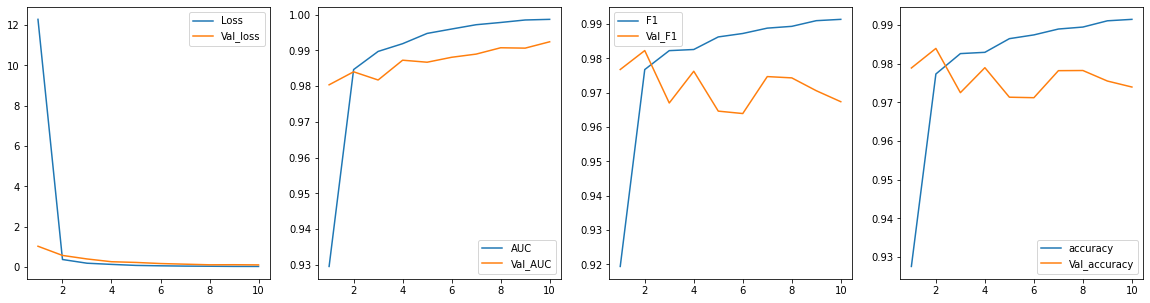

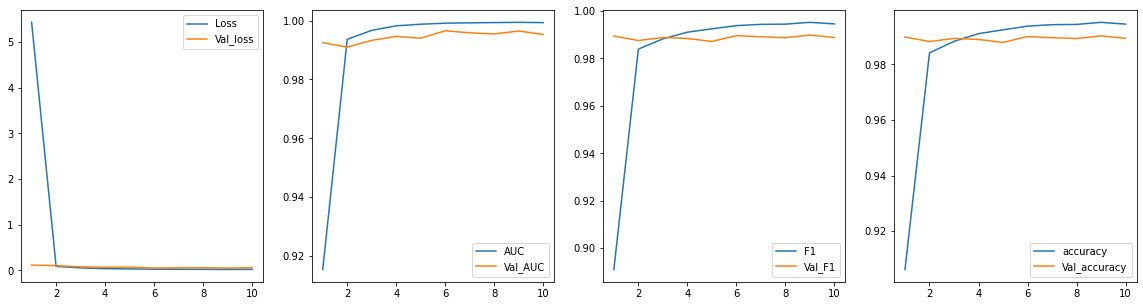

In [ ]:
import time

config={"architecture": "Unet",
                   "epochs": 10,
                   "batch_size": 16}

import pandas as pd
df = pd.DataFrame(columns=['Name', 'Loss', 'val_loss', "auc", "val_auc", "accuracy", "val_accuracy", "f1", "val_f1"])

for i in range(0, len(list(configs_fs))):
  run = wandb.init(project='kl-121-dissertation', reinit=True, config=config)
  print(i + 1, " loaded \n")
  conf = configs_fs[list(configs_fs)[i]]
  print(conf.PROJECT_TITLE, conf.type_)
  preproc = preprocessing.Preprocessor(conf)
  training = preproc.get_training_dataset("Train_in_Thailand/")
  evaluation = preproc.get_eval_dataset("Train_in_Thailand/")
  model.CONFIG = conf
  EPOCHS = 10
  wandb.run.name = conf.PROJECT_TITLE + "Feature-stack"
  start = time.time()
  EPO = [i for i in range(1, EPOCHS + 1)]
  model_custom = model.get_model()
  
  history = model_custom.fit(
      x=training,
      epochs=EPOCHS,
      steps_per_epoch=int(240*3 / conf.BATCH_SIZE),
      validation_data=evaluation,
      validation_steps=240*2,
      callbacks=[WandbCallback()]
      )
  end = time.time()
  print(f'Time for {EPOCHS} epochs is: ', end - start)
  Model_name = conf.PROJECT_TITLE + "_EPOCHS_" + str(EPOCHS)
  MODEL_DIR = 'gs://' + conf.BUCKET + "/" + conf.FOLDER + "/Models/" + Model_name
  model_custom.save(MODEL_DIR, save_format='tf')
  hist_keys = [*history.history]

  df.loc[i] = [conf.PROJECT_TITLE] + \
  [history.history["loss"][-1]] + [history.history["val_loss"][-1]] + \
  [history.history["auc"][-1]] + [history.history["val_auc"][-1]] + \
  [history.history["categorical_accuracy"][-1]] + [history.history["val_categorical_accuracy"][-1]] + \
  [history.history["f1"][-1]] + [history.history["val_f1"][-1]] \
  run.finish()

# Multiview-2


<b> The model </b>: Here we use the Keras implementation of the U-Net model. The modified U-Net model takes in two layers of inputs and each has a structure of UNET and and outputs per-pixel class probability. We will use categorical cross entropy as loss function and softmax as the last layer because we are working on a classification problem.

For each experiment, we will:
- Load the training and evaluation dataset from google cloud bucket into a `tf.data.Dataset`.
- Train the Multiview deep learning with 2 inputs  UNET model for 10 epochs
- Store the trained model in google cloud bucket for future prediction
- Store the losses and metrics using Wandb.ai

<b> Note:</b> The time to train the model could take up to 4-5 hours because we are training 37 UNET model that is not pretrained, but this is within the colab background execution runtime. If the connection cuts off, the experiment is continued where the training stops.

auc,▁▆▇▇████
custom_accuracy,▁▆▇▇█▇██
epoch,▁▂▃▄▅▆▇█
f1,▁▆▇▇█▇██
loss,█▁▁▁▁▁▁▁
val_auc,▁▅▄▆█▇██
val_custom_accuracy,▁█▄▁▇▅▆▅
val_f1,▂█▄▁▇▅▆▅
val_loss,█▃▃▂▁▁▁▁
GFLOPS,0.0
auc,0.99852


5  loaded 

S1A_sl_as m2
Epoch 1/10
45/45 [==============================] - 100s 1s/step - loss: 7.9827 - auc: 0.9588 - f1: 0.9561 - custom_accuracy: 0.9636 - val_loss: 1.4583 - val_auc: 0.9827 - val_f1: 0.9823 - val_custom_accuracy: 0.9841 - _timestamp: 1657891867.0000 - _runtime: 107.0000
Epoch 2/10
45/45 [==============================] - 63s 1s/step - loss: 0.4332 - auc: 0.9876 - f1: 0.9847 - custom_accuracy: 0.9850 - val_loss: 0.6288 - val_auc: 0.9843 - val_f1: 0.9833 - val_custom_accuracy: 0.9849 - _timestamp: 1657891931.0000 - _runtime: 171.0000
Epoch 3/10
45/45 [==============================] - 62s 1s/step - loss: 0.2220 - auc: 0.9904 - f1: 0.9866 - custom_accuracy: 0.9868 - val_loss: 0.2921 - val_auc: 0.9898 - val_f1: 0.9882 - val_custom_accuracy: 0.9890 - _timestamp: 1657891993.0000 - _runtime: 233.0000
Epoch 4/10
45/45 [==============================] - 63s 1s/step - loss: 0.1558 - auc: 0.9922 - f1: 0.9883 - custom_accuracy: 0.9885 - val_loss: 0.2883 - val_auc: 0.9878 - va

auc,▁▆▇▇▇▇▇███
custom_accuracy,▁▆▆▇▇▇▇███
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇▇▇█▇███
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▅▄▄▆▅█▇▇
val_custom_accuracy,▁▂▅▃▃▆▅█▇▆
val_f1,▁▂▅▃▃▆▅█▇▆
val_loss,█▄▂▂▂▁▂▁▁▁
GFLOPS,0.0
auc,0.99885


6  loaded 

S1A_el_sl m2
Epoch 1/10
45/45 [==============================] - 171s 3s/step - loss: 8.3966 - auc: 0.9410 - f1: 0.9313 - custom_accuracy: 0.9408 - val_loss: 0.2150 - val_auc: 0.9889 - val_f1: 0.9865 - val_custom_accuracy: 0.9874 - _timestamp: 1657892871.0000 - _runtime: 181.0000
Epoch 2/10
45/45 [==============================] - 110s 2s/step - loss: 0.1002 - auc: 0.9931 - f1: 0.9860 - custom_accuracy: 0.9863 - val_loss: 0.1257 - val_auc: 0.9920 - val_f1: 0.9894 - val_custom_accuracy: 0.9900 - _timestamp: 1657892981.0000 - _runtime: 291.0000
Epoch 3/10
45/45 [==============================] - 107s 2s/step - loss: 0.0680 - auc: 0.9952 - f1: 0.9879 - custom_accuracy: 0.9881 - val_loss: 0.1182 - val_auc: 0.9917 - val_f1: 0.9889 - val_custom_accuracy: 0.9896 - _timestamp: 1657893087.0000 - _runtime: 397.0000
Epoch 4/10
45/45 [==============================] - 109s 2s/step - loss: 0.0562 - auc: 0.9961 - f1: 0.9894 - custom_accuracy: 0.9895 - val_loss: 0.0816 - val_auc: 0.9937 -

auc,▁▇████████
custom_accuracy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▄▆▅▇█▇█▇
val_custom_accuracy,▁▅▄▆▅▇█▆█▆
val_f1,▁▅▄▆▅▇█▆█▆
val_loss,█▄▄▃▃▂▁▂▁▁
GFLOPS,0.0
auc,0.99922


7  loaded 

S1A_el_as m2
Epoch 1/10
45/45 [==============================] - 105s 2s/step - loss: 57.3101 - auc: 0.9317 - f1: 0.9306 - custom_accuracy: 0.9425 - val_loss: 1.0759 - val_auc: 0.9885 - val_f1: 0.9881 - val_custom_accuracy: 0.9888 - _timestamp: 1657893969.0000 - _runtime: 115.0000
Epoch 2/10
45/45 [==============================] - 65s 1s/step - loss: 0.5245 - auc: 0.9893 - f1: 0.9880 - custom_accuracy: 0.9881 - val_loss: 0.8191 - val_auc: 0.9886 - val_f1: 0.9879 - val_custom_accuracy: 0.9887 - _timestamp: 1657894034.0000 - _runtime: 180.0000
Epoch 3/10
45/45 [==============================] - 64s 1s/step - loss: 0.2657 - auc: 0.9927 - f1: 0.9912 - custom_accuracy: 0.9913 - val_loss: 0.5787 - val_auc: 0.9904 - val_f1: 0.9897 - val_custom_accuracy: 0.9902 - _timestamp: 1657894098.0000 - _runtime: 244.0000
Epoch 4/10
45/45 [==============================] - 62s 1s/step - loss: 0.1918 - auc: 0.9937 - f1: 0.9923 - custom_accuracy: 0.9924 - val_loss: 0.5058 - val_auc: 0.9906 - v

auc,▁▇████████
custom_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▁▅▅▆▆▅▃█▇
val_custom_accuracy,▂▁▆▇▆▆▅▁█▅
val_f1,▂▁▆▇▆▆▅▁█▅
val_loss,█▆▄▃▃▂▂▂▁▁
GFLOPS,0.0
auc,0.99634


8  loaded 

S1_el_sl_as m2
Epoch 1/10
45/45 [==============================] - 184s 3s/step - loss: 3.5131 - auc: 0.9634 - f1: 0.9566 - custom_accuracy: 0.9604 - val_loss: 0.1724 - val_auc: 0.9917 - val_f1: 0.9875 - val_custom_accuracy: 0.9880 - _timestamp: 1657894885.0000 - _runtime: 195.0000
Epoch 2/10
45/45 [==============================] - 117s 3s/step - loss: 0.1150 - auc: 0.9937 - f1: 0.9894 - custom_accuracy: 0.9895 - val_loss: 0.1114 - val_auc: 0.9939 - val_f1: 0.9917 - val_custom_accuracy: 0.9920 - _timestamp: 1657895001.0000 - _runtime: 311.0000
Epoch 3/10
45/45 [==============================] - 123s 3s/step - loss: 0.0692 - auc: 0.9956 - f1: 0.9916 - custom_accuracy: 0.9917 - val_loss: 0.0816 - val_auc: 0.9947 - val_f1: 0.9920 - val_custom_accuracy: 0.9924 - _timestamp: 1657895124.0000 - _runtime: 434.0000
Epoch 4/10
45/45 [==============================] - 105s 2s/step - loss: 0.0479 - auc: 0.9968 - f1: 0.9930 - custom_accuracy: 0.9931 - val_loss: 0.0750 - val_auc: 0.9948

auc,▁▇▇███████
custom_accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▅▅▅▄▆▆▇█
val_custom_accuracy,▁▇█▇█▆▇▇█▇
val_f1,▁▇█▇█▆▇▇█▇
val_loss,█▅▃▃▂▃▂▂▁▁
GFLOPS,0.0
auc,0.99888


9  loaded 

S1_el m2
Epoch 1/10
45/45 [==============================] - 176s 3s/step - loss: 212.1108 - auc: 0.8756 - f1: 0.8593 - custom_accuracy: 0.8805 - val_loss: 0.9367 - val_auc: 0.9378 - val_f1: 0.9144 - val_custom_accuracy: 0.9431 - _timestamp: 1657895926.0000 - _runtime: 186.0000
Epoch 2/10
45/45 [==============================] - 103s 2s/step - loss: 0.9752 - auc: 0.9551 - f1: 0.9380 - custom_accuracy: 0.9421 - val_loss: 0.8497 - val_auc: 0.9720 - val_f1: 0.9579 - val_custom_accuracy: 0.9654 - _timestamp: 1657896028.0000 - _runtime: 288.0000
Epoch 3/10
45/45 [==============================] - 104s 2s/step - loss: 0.3625 - auc: 0.9821 - f1: 0.9734 - custom_accuracy: 0.9743 - val_loss: 0.4709 - val_auc: 0.9862 - val_f1: 0.9843 - val_custom_accuracy: 0.9857 - _timestamp: 1657896133.0000 - _runtime: 393.0000
Epoch 4/10
45/45 [==============================] - 110s 2s/step - loss: 0.2129 - auc: 0.9891 - f1: 0.9827 - custom_accuracy: 0.9831 - val_loss: 0.4098 - val_auc: 0.9870 - v

auc,▁▆▇███████
custom_accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▅▇▇██████
val_custom_accuracy,▁▄▇███████
val_f1,▁▅████████
val_loss,█▇▄▄▃▂▂▁▁▁
GFLOPS,0.0
auc,0.99755


10  loaded 

S1_sl m2
Epoch 1/10
45/45 [==============================] - 136s 2s/step - loss: 1.6877 - auc: 0.9622 - f1: 0.9405 - custom_accuracy: 0.9477 - val_loss: 0.0880 - val_auc: 0.9922 - val_f1: 0.9844 - val_custom_accuracy: 0.9858 - _timestamp: 1657897048.0000 - _runtime: 145.0000
Epoch 2/10
45/45 [==============================] - 138s 3s/step - loss: 0.0719 - auc: 0.9957 - f1: 0.9842 - custom_accuracy: 0.9845 - val_loss: 0.0642 - val_auc: 0.9949 - val_f1: 0.9863 - val_custom_accuracy: 0.9874 - _timestamp: 1657897187.0000 - _runtime: 284.0000
Epoch 3/10
45/45 [==============================] - 119s 3s/step - loss: 0.0425 - auc: 0.9978 - f1: 0.9894 - custom_accuracy: 0.9896 - val_loss: 0.0664 - val_auc: 0.9942 - val_f1: 0.9861 - val_custom_accuracy: 0.9873 - _timestamp: 1657897307.0000 - _runtime: 404.0000
Epoch 4/10
45/45 [==============================] - 112s 3s/step - loss: 0.0271 - auc: 0.9987 - f1: 0.9929 - custom_accuracy: 0.9930 - val_loss: 0.0483 - val_auc: 0.9963 - va

auc,▁▇████████
custom_accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▃▅▇▇██▇█
val_custom_accuracy,▁▃▂▅▇█▇█▆▇
val_f1,▁▃▂▅▇█▇█▆▇
val_loss,█▅▆▃▂▂▂▁▂▁
GFLOPS,0.0
auc,0.9996


11  loaded 

S1_as m2
Epoch 1/10
45/45 [==============================] - 102s 1s/step - loss: 48.6969 - auc: 0.9574 - f1: 0.9533 - custom_accuracy: 0.9580 - val_loss: 1.6744 - val_auc: 0.9821 - val_f1: 0.9815 - val_custom_accuracy: 0.9833 - _timestamp: 1657898173.0000 - _runtime: 112.0000
Epoch 2/10
45/45 [==============================] - 77s 2s/step - loss: 0.6046 - auc: 0.9843 - f1: 0.9800 - custom_accuracy: 0.9805 - val_loss: 0.8179 - val_auc: 0.9843 - val_f1: 0.9834 - val_custom_accuracy: 0.9849 - _timestamp: 1657898250.0000 - _runtime: 189.0000
Epoch 3/10
45/45 [==============================] - 112s 3s/step - loss: 0.3743 - auc: 0.9873 - f1: 0.9833 - custom_accuracy: 0.9836 - val_loss: 0.4156 - val_auc: 0.9875 - val_f1: 0.9855 - val_custom_accuracy: 0.9866 - _timestamp: 1657898362.0000 - _runtime: 301.0000
Epoch 4/10
45/45 [==============================] - 122s 3s/step - loss: 0.2027 - auc: 0.9912 - f1: 0.9877 - custom_accuracy: 0.9879 - val_loss: 0.2547 - val_auc: 0.9901 - va

auc,▁▆▆▇▇█████
custom_accuracy,▁▆▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▆▇▇█████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▄▅▄▇▆▇▇█
val_custom_accuracy,▁▂▄▆▄█▇███
val_f1,▁▂▄▆▄█▇███
val_loss,█▄▃▂▂▁▁▁▁▁
GFLOPS,0.0
auc,0.99606


12  loaded 

S1_sl_as m2
Epoch 1/10
45/45 [==============================] - 151s 2s/step - loss: 426.4315 - auc: 0.9294 - f1: 0.9270 - custom_accuracy: 0.9437 - val_loss: 1.1026 - val_auc: 0.9812 - val_f1: 0.9786 - val_custom_accuracy: 0.9804 - _timestamp: 1657899407.0000 - _runtime: 159.0000
Epoch 2/10
45/45 [==============================] - 95s 2s/step - loss: 0.4983 - auc: 0.9838 - f1: 0.9784 - custom_accuracy: 0.9789 - val_loss: 0.6249 - val_auc: 0.9824 - val_f1: 0.9800 - val_custom_accuracy: 0.9818 - _timestamp: 1657899503.0000 - _runtime: 255.0000
Epoch 3/10
45/45 [==============================] - 93s 2s/step - loss: 0.3079 - auc: 0.9882 - f1: 0.9840 - custom_accuracy: 0.9843 - val_loss: 0.3200 - val_auc: 0.9876 - val_f1: 0.9857 - val_custom_accuracy: 0.9867 - _timestamp: 1657899596.0000 - _runtime: 348.0000
Epoch 4/10
45/45 [==============================] - 94s 2s/step - loss: 0.2494 - auc: 0.9895 - f1: 0.9856 - custom_accuracy: 0.9858 - val_loss: 0.4211 - val_auc: 0.9846 - 

auc,▁▇▇▇████▇█
custom_accuracy,▁▆▇▇████▇█
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇█████▇█
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▃▃▅▄▇▁▂█▇▇
val_custom_accuracy,▃▄▆▅█▁▂█▇▇
val_f1,▄▄▆▅█▁▂█▇▇
val_loss,█▅▃▃▂▆▄▁▁▁
GFLOPS,0.0
auc,0.99284


13  loaded 

S1_el_sl m2
Epoch 1/10
45/45 [==============================] - 120s 2s/step - loss: 7.4995 - auc: 0.8824 - f1: 0.8596 - custom_accuracy: 0.8814 - val_loss: 0.6217 - val_auc: 0.9397 - val_f1: 0.9071 - val_custom_accuracy: 0.9417 - _timestamp: 1657900490.0000 - _runtime: 130.0000
Epoch 2/10
45/45 [==============================] - 79s 2s/step - loss: 0.1719 - auc: 0.9881 - f1: 0.9742 - custom_accuracy: 0.9753 - val_loss: 0.1100 - val_auc: 0.9928 - val_f1: 0.9877 - val_custom_accuracy: 0.9883 - _timestamp: 1657900569.0000 - _runtime: 209.0000
Epoch 3/10
45/45 [==============================] - 73s 2s/step - loss: 0.0783 - auc: 0.9948 - f1: 0.9869 - custom_accuracy: 0.9871 - val_loss: 0.1822 - val_auc: 0.9894 - val_f1: 0.9855 - val_custom_accuracy: 0.9866 - _timestamp: 1657900644.0000 - _runtime: 284.0000
Epoch 4/10
45/45 [==============================] - 74s 2s/step - loss: 0.0468 - auc: 0.9968 - f1: 0.9915 - custom_accuracy: 0.9916 - val_loss: 0.0780 - val_auc: 0.9939 - va

auc,▁▇████████
custom_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁█▇███▇███
val_custom_accuracy,▁█▇██▇▇██▇
val_f1,▁█████▇███
val_loss,█▂▂▁▁▂▂▁▁▁
GFLOPS,0.0
auc,0.99917


14  loaded 

S1_el_as m2
Epoch 1/10
45/45 [==============================] - 145s 2s/step - loss: 670.8223 - auc: 0.9407 - f1: 0.9364 - custom_accuracy: 0.9436 - val_loss: 0.4773 - val_auc: 0.9815 - val_f1: 0.9752 - val_custom_accuracy: 0.9767 - _timestamp: 1657901533.0000 - _runtime: 155.0000
Epoch 2/10
45/45 [==============================] - 82s 2s/step - loss: 0.5011 - auc: 0.9856 - f1: 0.9827 - custom_accuracy: 0.9831 - val_loss: 0.8624 - val_auc: 0.9871 - val_f1: 0.9864 - val_custom_accuracy: 0.9873 - _timestamp: 1657901616.0000 - _runtime: 238.0000
Epoch 3/10
45/45 [==============================] - 90s 2s/step - loss: 0.2680 - auc: 0.9916 - f1: 0.9894 - custom_accuracy: 0.9896 - val_loss: 1.1460 - val_auc: 0.9803 - val_f1: 0.9783 - val_custom_accuracy: 0.9807 - _timestamp: 1657901707.0000 - _runtime: 329.0000
Epoch 4/10
45/45 [==============================] - 101s 2s/step - loss: 0.2033 - auc: 0.9932 - f1: 0.9914 - custom_accuracy: 0.9914 - val_loss: 0.7972 - val_auc: 0.9851 -

auc,▁▇▇███████
custom_accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▇█▆▇▁▅▇██▇
val_custom_accuracy,▄█▆▇▁▄▇██▇
val_f1,▅█▆▇▁▄▇██▇
val_loss,▁▃▄▃█▄▂▁▁▁
GFLOPS,0.0
auc,0.99555


15  loaded 

L8SR_el_sl_as m2
Epoch 1/10
45/45 [==============================] - 99s 1s/step - loss: 22.4846 - auc: 0.9081 - f1: 0.9065 - custom_accuracy: 0.9231 - val_loss: 0.9585 - val_auc: 0.9789 - val_f1: 0.9741 - val_custom_accuracy: 0.9760 - _timestamp: 1657902628.0000 - _runtime: 109.0000
Epoch 2/10
45/45 [==============================] - 66s 1s/step - loss: 0.6605 - auc: 0.9756 - f1: 0.9664 - custom_accuracy: 0.9677 - val_loss: 0.9822 - val_auc: 0.9324 - val_f1: 0.9042 - val_custom_accuracy: 0.9194 - _timestamp: 1657902696.0000 - _runtime: 177.0000
Epoch 3/10
45/45 [==============================] - 67s 2s/step - loss: 0.2876 - auc: 0.9852 - f1: 0.9758 - custom_accuracy: 0.9764 - val_loss: 0.4304 - val_auc: 0.9776 - val_f1: 0.9590 - val_custom_accuracy: 0.9636 - _timestamp: 1657902761.0000 - _runtime: 242.0000
Epoch 4/10
45/45 [==============================] - 67s 2s/step - loss: 0.1705 - auc: 0.9898 - f1: 0.9794 - custom_accuracy: 0.9799 - val_loss: 0.3527 - val_auc: 0.9835

auc,▁▆▇▇██████
custom_accuracy,▁▅▆▇▇▇█▇██
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇▇▇▇████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▆▁▆▆▇▇▇▇██
val_custom_accuracy,▆▁▅▆▇▇▇▆██
val_f1,▇▁▅▆▇▇▇▆██
val_loss,██▄▃▂▂▂▂▁▁
GFLOPS,0.0
auc,0.99922


16  loaded 

L8SR_el m2
Epoch 1/10
45/45 [==============================] - 174s 3s/step - loss: 39.1076 - auc: 0.8730 - f1: 0.8681 - custom_accuracy: 0.8876 - val_loss: 1.0207 - val_auc: 0.9514 - val_f1: 0.9371 - val_custom_accuracy: 0.9509 - _timestamp: 1657903706.0000 - _runtime: 184.0000
Epoch 2/10
45/45 [==============================] - 109s 2s/step - loss: 1.5903 - auc: 0.9393 - f1: 0.9244 - custom_accuracy: 0.9308 - val_loss: 0.2752 - val_auc: 0.9829 - val_f1: 0.9770 - val_custom_accuracy: 0.9794 - _timestamp: 1657903815.0000 - _runtime: 293.0000
Epoch 3/10
45/45 [==============================] - 109s 2s/step - loss: 0.4704 - auc: 0.9721 - f1: 0.9562 - custom_accuracy: 0.9585 - val_loss: 0.0642 - val_auc: 0.9956 - val_f1: 0.9864 - val_custom_accuracy: 0.9872 - _timestamp: 1657903924.0000 - _runtime: 402.0000
Epoch 4/10
45/45 [==============================] - 108s 2s/step - loss: 0.1133 - auc: 0.9923 - f1: 0.9804 - custom_accuracy: 0.9808 - val_loss: 0.0492 - val_auc: 0.9965 -

auc,▁▅▆███████
custom_accuracy,▁▄▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▄▆▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▆▇███████
val_custom_accuracy,▁▅▇▇██████
val_f1,▁▆▇▇██████
val_loss,█▃▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99954


17  loaded 

L8SR_sl m2
Epoch 1/10
45/45 [==============================] - 335s 4s/step - loss: 0.1820 - auc: 0.9836 - f1: 0.9562 - custom_accuracy: 0.9623 - val_loss: 0.0293 - val_auc: 0.9977 - val_f1: 0.9930 - val_custom_accuracy: 0.9932 - _timestamp: 1657905232.0000 - _runtime: 344.0000
Epoch 2/10
45/45 [==============================] - 148s 3s/step - loss: 0.0739 - auc: 0.9950 - f1: 0.9823 - custom_accuracy: 0.9837 - val_loss: 0.0360 - val_auc: 0.9983 - val_f1: 0.9882 - val_custom_accuracy: 0.9890 - _timestamp: 1657905383.0000 - _runtime: 495.0000
Epoch 3/10
45/45 [==============================] - 128s 3s/step - loss: 0.0396 - auc: 0.9979 - f1: 0.9901 - custom_accuracy: 0.9903 - val_loss: 0.0173 - val_auc: 0.9993 - val_f1: 0.9948 - val_custom_accuracy: 0.9949 - _timestamp: 1657905509.0000 - _runtime: 621.0000
Epoch 4/10
45/45 [==============================] - 117s 3s/step - loss: 0.0193 - auc: 0.9994 - f1: 0.9938 - custom_accuracy: 0.9939 - val_loss: 0.0165 - val_auc: 0.9993 - 

auc,▁▆▇███████
custom_accuracy,▁▅▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇███████
loss,█▄▂▁▁▁▁▁▁▁
val_auc,▁▃▇▇▇▆█▆██
val_custom_accuracy,▅▁▇▇▇▇█▇██
val_f1,▅▁▇▇▇▇█▇██
val_loss,▆█▃▂▂▂▁▂▁▁
GFLOPS,0.0
auc,0.99973


18  loaded 

L8SR_as m2
Epoch 1/10
45/45 [==============================] - 161s 2s/step - loss: 25.2404 - auc: 0.9452 - f1: 0.9348 - custom_accuracy: 0.9442 - val_loss: 2.2219 - val_auc: 0.9799 - val_f1: 0.9787 - val_custom_accuracy: 0.9807 - _timestamp: 1657906602.0000 - _runtime: 171.0000
Epoch 2/10
45/45 [==============================] - 110s 2s/step - loss: 1.1479 - auc: 0.9777 - f1: 0.9738 - custom_accuracy: 0.9745 - val_loss: 1.4128 - val_auc: 0.9817 - val_f1: 0.9811 - val_custom_accuracy: 0.9829 - _timestamp: 1657906712.0000 - _runtime: 281.0000
Epoch 3/10
45/45 [==============================] - 103s 2s/step - loss: 0.4842 - auc: 0.9855 - f1: 0.9823 - custom_accuracy: 0.9827 - val_loss: 0.6529 - val_auc: 0.9847 - val_f1: 0.9837 - val_custom_accuracy: 0.9852 - _timestamp: 1657906815.0000 - _runtime: 384.0000
Epoch 4/10
45/45 [==============================] - 108s 2s/step - loss: 0.2014 - auc: 0.9913 - f1: 0.9882 - custom_accuracy: 0.9883 - val_loss: 0.2330 - val_auc: 0.9907 -

auc,▁▅▆▇▇█████
custom_accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▆▇▇█████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▃▅▇█████
val_custom_accuracy,▁▂▃▅▇█████
val_f1,▁▂▃▅▇█████
val_loss,█▅▃▂▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99966


19  loaded 

L8SR_sl_as m2
Epoch 1/10
45/45 [==============================] - 182s 3s/step - loss: 25.1066 - auc: 0.9350 - f1: 0.9229 - custom_accuracy: 0.9384 - val_loss: 1.0749 - val_auc: 0.9783 - val_f1: 0.9719 - val_custom_accuracy: 0.9751 - _timestamp: 1657907854.0000 - _runtime: 192.0000
Epoch 2/10
45/45 [==============================] - 123s 3s/step - loss: 0.4564 - auc: 0.9803 - f1: 0.9699 - custom_accuracy: 0.9709 - val_loss: 0.4078 - val_auc: 0.9824 - val_f1: 0.9801 - val_custom_accuracy: 0.9821 - _timestamp: 1657907976.0000 - _runtime: 314.0000
Epoch 3/10
45/45 [==============================] - 118s 3s/step - loss: 0.1768 - auc: 0.9885 - f1: 0.9787 - custom_accuracy: 0.9792 - val_loss: 3.5521 - val_auc: 0.4523 - val_f1: 0.4599 - val_custom_accuracy: 0.6519 - _timestamp: 1657908097.0000 - _runtime: 435.0000
Epoch 4/10
45/45 [==============================] - 124s 3s/step - loss: 0.0997 - auc: 0.9925 - f1: 0.9823 - custom_accuracy: 0.9826 - val_loss: 3.9611 - val_auc: 0.321

auc,▁▆▇▇▇█████
custom_accuracy,▁▅▆▇▇▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▆▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁
val_auc,██▂▁▇▇▇███
val_custom_accuracy,██▂▁▅▆▆▇██
val_f1,██▂▁▆▆▇▇██
val_loss,▃▂▇█▂▂▂▁▁▁
GFLOPS,0.0
auc,0.99935


20  loaded 

L8SR_el_sl m2
Epoch 1/10
45/45 [==============================] - 94s 1s/step - loss: 20.9820 - auc: 0.8646 - f1: 0.8588 - custom_accuracy: 0.8833 - val_loss: 0.4473 - val_auc: 0.9527 - val_f1: 0.9497 - val_custom_accuracy: 0.9617 - _timestamp: 1657908905.0000 - _runtime: 104.0000
Epoch 2/10
45/45 [==============================] - 63s 1s/step - loss: 0.5837 - auc: 0.9448 - f1: 0.9066 - custom_accuracy: 0.9166 - val_loss: 0.0356 - val_auc: 0.9972 - val_f1: 0.9914 - val_custom_accuracy: 0.9917 - _timestamp: 1657908968.0000 - _runtime: 167.0000
Epoch 3/10
45/45 [==============================] - 67s 2s/step - loss: 0.0515 - auc: 0.9966 - f1: 0.9879 - custom_accuracy: 0.9881 - val_loss: 0.0258 - val_auc: 0.9981 - val_f1: 0.9939 - val_custom_accuracy: 0.9940 - _timestamp: 1657909035.0000 - _runtime: 234.0000
Epoch 4/10
45/45 [==============================] - 79s 2s/step - loss: 0.0298 - auc: 0.9985 - f1: 0.9917 - custom_accuracy: 0.9918 - val_loss: 0.0200 - val_auc: 0.9989 - 

auc,▁▅████████
custom_accuracy,▁▃▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▃████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁█████████
val_custom_accuracy,▁▇▇███████
val_f1,▁▇████████
val_loss,█▁▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99974


21  loaded 

L8SR_el_as m2
Epoch 1/10
45/45 [==============================] - 146s 2s/step - loss: 5.1007 - auc: 0.9322 - f1: 0.9096 - custom_accuracy: 0.9188 - val_loss: 0.3548 - val_auc: 0.9842 - val_f1: 0.9739 - val_custom_accuracy: 0.9763 - _timestamp: 1657909995.0000 - _runtime: 156.0000
Epoch 2/10
45/45 [==============================] - 85s 2s/step - loss: 0.2390 - auc: 0.9853 - f1: 0.9685 - custom_accuracy: 0.9697 - val_loss: 0.0868 - val_auc: 0.9932 - val_f1: 0.9864 - val_custom_accuracy: 0.9871 - _timestamp: 1657910080.0000 - _runtime: 241.0000
Epoch 3/10
45/45 [==============================] - 75s 2s/step - loss: 0.0668 - auc: 0.9956 - f1: 0.9858 - custom_accuracy: 0.9860 - val_loss: 0.0235 - val_auc: 0.9985 - val_f1: 0.9944 - val_custom_accuracy: 0.9945 - _timestamp: 1657910155.0000 - _runtime: 316.0000
Epoch 4/10
45/45 [==============================] - 78s 2s/step - loss: 0.0249 - auc: 0.9988 - f1: 0.9922 - custom_accuracy: 0.9923 - val_loss: 0.0156 - val_auc: 0.9991 - 

auc,▁▆████████
custom_accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▅▇███████
val_custom_accuracy,▁▅▇█▇█▇███
val_f1,▁▅▇███████
val_loss,█▃▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.9998


22  loaded 

L8SR_S1_as m2
Epoch 1/10
45/45 [==============================] - 147s 2s/step - loss: 4.1226 - auc: 0.9574 - f1: 0.9499 - custom_accuracy: 0.9555 - val_loss: 1.0999 - val_auc: 0.9438 - val_f1: 0.9245 - val_custom_accuracy: 0.9325 - _timestamp: 1657910985.0000 - _runtime: 158.0000
Epoch 2/10
45/45 [==============================] - 91s 2s/step - loss: 0.3070 - auc: 0.9872 - f1: 0.9798 - custom_accuracy: 0.9803 - val_loss: 0.2591 - val_auc: 0.9862 - val_f1: 0.9829 - val_custom_accuracy: 0.9843 - _timestamp: 1657911075.0000 - _runtime: 248.0000
Epoch 3/10
45/45 [==============================] - 96s 2s/step - loss: 0.1241 - auc: 0.9923 - f1: 0.9839 - custom_accuracy: 0.9842 - val_loss: 0.0721 - val_auc: 0.9946 - val_f1: 0.9888 - val_custom_accuracy: 0.9894 - _timestamp: 1657911171.0000 - _runtime: 344.0000
Epoch 4/10
45/45 [==============================] - 103s 2s/step - loss: 0.0369 - auc: 0.9979 - f1: 0.9910 - custom_accuracy: 0.9911 - val_loss: 0.0196 - val_auc: 0.9989 -

auc,▁▆▇███████
custom_accuracy,▁▅▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▆▇██████
loss,█▂▁▁▁▁▁▁▁▁
val_auc,▁▆▇███████
val_custom_accuracy,▁▇▇███████
val_f1,▁▇▇███████
val_loss,█▃▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99977


23  loaded 

L8SR_S1_el m2
Epoch 1/10
45/45 [==============================] - 178s 3s/step - loss: 6.5394 - auc: 0.9162 - f1: 0.8917 - custom_accuracy: 0.9058 - val_loss: 0.0427 - val_auc: 0.9967 - val_f1: 0.9926 - val_custom_accuracy: 0.9928 - _timestamp: 1657912218.0000 - _runtime: 189.0000
Epoch 2/10
45/45 [==============================] - 103s 2s/step - loss: 0.0640 - auc: 0.9960 - f1: 0.9843 - custom_accuracy: 0.9846 - val_loss: 0.0389 - val_auc: 0.9972 - val_f1: 0.9940 - val_custom_accuracy: 0.9941 - _timestamp: 1657912320.0000 - _runtime: 291.0000
Epoch 3/10
45/45 [==============================] - 93s 2s/step - loss: 0.0275 - auc: 0.9984 - f1: 0.9932 - custom_accuracy: 0.9933 - val_loss: 0.0257 - val_auc: 0.9982 - val_f1: 0.9945 - val_custom_accuracy: 0.9946 - _timestamp: 1657912414.0000 - _runtime: 385.0000
Epoch 4/10
45/45 [==============================] - 96s 2s/step - loss: 0.0218 - auc: 0.9988 - f1: 0.9944 - custom_accuracy: 0.9944 - val_loss: 0.0286 - val_auc: 0.9980 -

auc,▁█████████
custom_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▅▄▆▇▇▇▇█
val_custom_accuracy,▁▄▅▅▇▇▇▇▆█
val_f1,▁▄▅▅▇▇▇▇▆█
val_loss,█▇▄▅▂▂▂▂▂▁
GFLOPS,0.0
auc,0.99978


24  loaded 

L8SR_S1_sl m2
Epoch 1/10
45/45 [==============================] - 95s 1s/step - loss: 0.7553 - auc: 0.9542 - f1: 0.9156 - custom_accuracy: 0.9301 - val_loss: 0.0200 - val_auc: 0.9992 - val_f1: 0.9938 - val_custom_accuracy: 0.9940 - _timestamp: 1657913131.0000 - _runtime: 105.0000
Epoch 2/10
45/45 [==============================] - 61s 1s/step - loss: 0.0223 - auc: 0.9992 - f1: 0.9933 - custom_accuracy: 0.9933 - val_loss: 0.0142 - val_auc: 0.9994 - val_f1: 0.9956 - val_custom_accuracy: 0.9957 - _timestamp: 1657913191.0000 - _runtime: 165.0000
Epoch 3/10
45/45 [==============================] - 63s 1s/step - loss: 0.0135 - auc: 0.9996 - f1: 0.9957 - custom_accuracy: 0.9957 - val_loss: 0.0129 - val_auc: 0.9994 - val_f1: 0.9960 - val_custom_accuracy: 0.9960 - _timestamp: 1657913253.0000 - _runtime: 227.0000
Epoch 4/10
45/45 [==============================] - 69s 2s/step - loss: 0.0107 - auc: 0.9997 - f1: 0.9965 - custom_accuracy: 0.9965 - val_loss: 0.0126 - val_auc: 0.9994 - v

auc,▁█████████
custom_accuracy,▁█████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁█████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▃▄▄▇██▆█▇
val_custom_accuracy,▁▅▆▆▇██▇██
val_f1,▁▅▆▆▇██▇██
val_loss,█▄▄▃▂▁▁▂▁▁
GFLOPS,0.0
auc,0.99989


25  loaded 

L8SR_S1_sl_as m2
Epoch 1/10
45/45 [==============================] - 139s 2s/step - loss: 4.8503 - auc: 0.9469 - f1: 0.9411 - custom_accuracy: 0.9514 - val_loss: 1.5563 - val_auc: 0.9779 - val_f1: 0.9734 - val_custom_accuracy: 0.9754 - _timestamp: 1657914007.0000 - _runtime: 148.0000
Epoch 2/10
45/45 [==============================] - 92s 2s/step - loss: 0.4070 - auc: 0.9854 - f1: 0.9781 - custom_accuracy: 0.9786 - val_loss: 0.3492 - val_auc: 0.9857 - val_f1: 0.9830 - val_custom_accuracy: 0.9844 - _timestamp: 1657914100.0000 - _runtime: 241.0000
Epoch 3/10
45/45 [==============================] - 82s 2s/step - loss: 0.1632 - auc: 0.9906 - f1: 0.9822 - custom_accuracy: 0.9825 - val_loss: 0.2330 - val_auc: 0.9855 - val_f1: 0.9814 - val_custom_accuracy: 0.9830 - _timestamp: 1657914182.0000 - _runtime: 323.0000
Epoch 4/10
45/45 [==============================] - 82s 2s/step - loss: 0.1132 - auc: 0.9925 - f1: 0.9835 - custom_accuracy: 0.9838 - val_loss: 0.1853 - val_auc: 0.9867

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▆▇▇▇█████
custom_accuracy,▁▅▆▆▇▇████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▆▇▇▇████
loss,█▂▁▁▁▁▁▁▁▁
val_auc,▁▄▃▄▆▇▇███
val_custom_accuracy,▁▄▄▄▆▆▇▇██
val_f1,▁▄▄▄▆▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99929


26  loaded 

L8SR_S1_el_sl m2
Epoch 1/10
45/45 [==============================] - 147s 2s/step - loss: 17.0678 - auc: 0.8972 - f1: 0.8793 - custom_accuracy: 0.8986 - val_loss: 0.2602 - val_auc: 0.9904 - val_f1: 0.9880 - val_custom_accuracy: 0.9886 - _timestamp: 1657914916.0000 - _runtime: 157.0000
Epoch 2/10
45/45 [==============================] - 73s 2s/step - loss: 0.1866 - auc: 0.9886 - f1: 0.9796 - custom_accuracy: 0.9801 - val_loss: 0.0954 - val_auc: 0.9949 - val_f1: 0.9926 - val_custom_accuracy: 0.9928 - _timestamp: 1657914989.0000 - _runtime: 230.0000
Epoch 3/10
45/45 [==============================] - 82s 2s/step - loss: 0.0913 - auc: 0.9944 - f1: 0.9888 - custom_accuracy: 0.9889 - val_loss: 0.0806 - val_auc: 0.9957 - val_f1: 0.9938 - val_custom_accuracy: 0.9939 - _timestamp: 1657915070.0000 - _runtime: 311.0000
Epoch 4/10
45/45 [==============================] - 102s 2s/step - loss: 0.0461 - auc: 0.9970 - f1: 0.9930 - custom_accuracy: 0.9931 - val_loss: 0.0424 - val_auc: 0.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▅▆██████
val_custom_accuracy,▁▅▆▆▇▇██▇█
val_f1,▁▅▆▆▇▇██▇█
val_loss,█▃▃▂▁▁▁▁▁▁
GFLOPS,0.0
auc,0.9998


27  loaded 

L8SR_S1_el_as m2
Epoch 1/10
45/45 [==============================] - 118s 2s/step - loss: 7.0228 - auc: 0.9394 - f1: 0.9351 - custom_accuracy: 0.9460 - val_loss: 1.0369 - val_auc: 0.9823 - val_f1: 0.9814 - val_custom_accuracy: 0.9833 - _timestamp: 1657915947.0000 - _runtime: 127.0000
Epoch 2/10
45/45 [==============================] - 76s 2s/step - loss: 0.3188 - auc: 0.9889 - f1: 0.9851 - custom_accuracy: 0.9854 - val_loss: 0.3453 - val_auc: 0.9871 - val_f1: 0.9852 - val_custom_accuracy: 0.9864 - _timestamp: 1657916024.0000 - _runtime: 204.0000
Epoch 3/10
45/45 [==============================] - 87s 2s/step - loss: 0.1382 - auc: 0.9928 - f1: 0.9889 - custom_accuracy: 0.9890 - val_loss: 0.1918 - val_auc: 0.9914 - val_f1: 0.9892 - val_custom_accuracy: 0.9897 - _timestamp: 1657916110.0000 - _runtime: 290.0000
Epoch 4/10
45/45 [==============================] - 118s 3s/step - loss: 0.0674 - auc: 0.9960 - f1: 0.9927 - custom_accuracy: 0.9928 - val_loss: 0.1187 - val_auc: 0.994

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇▇███████
custom_accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▃▅▆▇▇▇███
val_custom_accuracy,▁▃▅▆▇▇████
val_f1,▁▃▅▆▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99927


28  loaded 

L8SR_S1_sl_el_as m2
Epoch 1/10
45/45 [==============================] - 161s 3s/step - loss: 9.9586 - auc: 0.9139 - f1: 0.9023 - custom_accuracy: 0.9175 - val_loss: 0.5521 - val_auc: 0.9705 - val_f1: 0.9623 - val_custom_accuracy: 0.9688 - _timestamp: 1657917165.0000 - _runtime: 171.0000
Epoch 2/10
45/45 [==============================] - 104s 2s/step - loss: 0.3109 - auc: 0.9829 - f1: 0.9668 - custom_accuracy: 0.9681 - val_loss: 1.5566 - val_auc: 0.8308 - val_f1: 0.7765 - val_custom_accuracy: 0.8325 - _timestamp: 1657917271.0000 - _runtime: 277.0000
Epoch 3/10
45/45 [==============================] - 103s 2s/step - loss: 0.1237 - auc: 0.9920 - f1: 0.9818 - custom_accuracy: 0.9822 - val_loss: 1.1749 - val_auc: 0.8532 - val_f1: 0.7867 - val_custom_accuracy: 0.8438 - _timestamp: 1657917374.0000 - _runtime: 380.0000
Epoch 4/10
45/45 [==============================] - 98s 2s/step - loss: 0.0770 - auc: 0.9949 - f1: 0.9864 - custom_accuracy: 0.9866 - val_loss: 0.2828 - val_auc: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇▇███████
custom_accuracy,▁▆▇▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▇▁▂▇▆█████
val_custom_accuracy,▇▁▁▆▄▇████
val_f1,▇▁▁▆▄▇████
val_loss,▃█▆▂▃▁▁▁▁▁
GFLOPS,0.0
auc,0.99933


29  loaded 

L8SR_S1A_as m2
Epoch 1/10
45/45 [==============================] - 156s 2s/step - loss: 61.4951 - auc: 0.9337 - f1: 0.9215 - custom_accuracy: 0.9414 - val_loss: 0.2760 - val_auc: 0.9815 - val_f1: 0.9726 - val_custom_accuracy: 0.9746 - _timestamp: 1657918329.0000 - _runtime: 167.0000
Epoch 2/10
45/45 [==============================] - 98s 2s/step - loss: 0.1588 - auc: 0.9890 - f1: 0.9790 - custom_accuracy: 0.9795 - val_loss: 0.1550 - val_auc: 0.9854 - val_f1: 0.9811 - val_custom_accuracy: 0.9829 - _timestamp: 1657918427.0000 - _runtime: 265.0000
Epoch 3/10
45/45 [==============================] - 101s 2s/step - loss: 0.1110 - auc: 0.9909 - f1: 0.9821 - custom_accuracy: 0.9825 - val_loss: 0.1001 - val_auc: 0.9896 - val_f1: 0.9813 - val_custom_accuracy: 0.9829 - _timestamp: 1657918528.0000 - _runtime: 366.0000
Epoch 4/10
45/45 [==============================] - 89s 2s/step - loss: 0.0768 - auc: 0.9939 - f1: 0.9843 - custom_accuracy: 0.9846 - val_loss: 0.0651 - val_auc: 0.9947

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇▇▇██████
custom_accuracy,▁▆▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇▇▇█████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▄▆▇█████
val_custom_accuracy,▁▄▄▄▆▇████
val_f1,▁▄▄▄▆▇████
val_loss,█▅▃▂▂▁▁▁▁▁
GFLOPS,0.0
auc,0.99941


30  loaded 

L8SR_S1A_el m2
Epoch 1/10
45/45 [==============================] - 132s 2s/step - loss: 15.7198 - auc: 0.9018 - f1: 0.8868 - custom_accuracy: 0.9041 - val_loss: 0.0479 - val_auc: 0.9963 - val_f1: 0.9932 - val_custom_accuracy: 0.9934 - _timestamp: 1657919456.0000 - _runtime: 142.0000
Epoch 2/10
45/45 [==============================] - 102s 2s/step - loss: 0.1034 - auc: 0.9926 - f1: 0.9762 - custom_accuracy: 0.9769 - val_loss: 0.0314 - val_auc: 0.9978 - val_f1: 0.9948 - val_custom_accuracy: 0.9949 - _timestamp: 1657919558.0000 - _runtime: 244.0000
Epoch 3/10
45/45 [==============================] - 106s 2s/step - loss: 0.0289 - auc: 0.9983 - f1: 0.9930 - custom_accuracy: 0.9930 - val_loss: 0.0173 - val_auc: 0.9989 - val_f1: 0.9960 - val_custom_accuracy: 0.9961 - _timestamp: 1657919664.0000 - _runtime: 350.0000
Epoch 4/10
45/45 [==============================] - 106s 2s/step - loss: 0.0170 - auc: 0.9993 - f1: 0.9947 - custom_accuracy: 0.9947 - val_loss: 0.0140 - val_auc: 0.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▆████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▇▇█▇████
val_custom_accuracy,▁▄▇▇▇▇▇▇██
val_f1,▁▄▇▇▇▇▇▇██
val_loss,█▅▂▂▂▂▁▁▁▁
GFLOPS,0.0
auc,0.9998


31  loaded 

L8SR_S1A_sl m2
Epoch 1/10
45/45 [==============================] - 109s 2s/step - loss: 3.8810 - auc: 0.9590 - f1: 0.9380 - custom_accuracy: 0.9450 - val_loss: 0.0615 - val_auc: 0.9955 - val_f1: 0.9927 - val_custom_accuracy: 0.9930 - _timestamp: 1657920579.0000 - _runtime: 120.0000
Epoch 2/10
45/45 [==============================] - 65s 1s/step - loss: 0.0496 - auc: 0.9968 - f1: 0.9895 - custom_accuracy: 0.9896 - val_loss: 0.0282 - val_auc: 0.9979 - val_f1: 0.9947 - val_custom_accuracy: 0.9948 - _timestamp: 1657920644.0000 - _runtime: 185.0000
Epoch 3/10
45/45 [==============================] - 61s 1s/step - loss: 0.0297 - auc: 0.9982 - f1: 0.9930 - custom_accuracy: 0.9930 - val_loss: 0.0185 - val_auc: 0.9987 - val_f1: 0.9960 - val_custom_accuracy: 0.9961 - _timestamp: 1657920705.0000 - _runtime: 246.0000
Epoch 4/10
45/45 [==============================] - 60s 1s/step - loss: 0.0199 - auc: 0.9988 - f1: 0.9951 - custom_accuracy: 0.9951 - val_loss: 0.0135 - val_auc: 0.9992 -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▇▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▅▆▇▇█████
val_custom_accuracy,▁▄▆▇▇█▇▇▇█
val_f1,▁▄▆▇▇█▇▇▇█
val_loss,█▄▂▂▂▁▁▁▁▁
GFLOPS,0.0
auc,0.99984


32  loaded 

L8SR_S1A_sl_as m2
Epoch 1/10
45/45 [==============================] - 153s 2s/step - loss: 3.8646 - auc: 0.9563 - f1: 0.9450 - custom_accuracy: 0.9525 - val_loss: 0.1289 - val_auc: 0.9892 - val_f1: 0.9801 - val_custom_accuracy: 0.9815 - _timestamp: 1657921404.0000 - _runtime: 163.0000
Epoch 2/10
45/45 [==============================] - 91s 2s/step - loss: 0.0843 - auc: 0.9939 - f1: 0.9862 - custom_accuracy: 0.9864 - val_loss: 0.0517 - val_auc: 0.9965 - val_f1: 0.9914 - val_custom_accuracy: 0.9917 - _timestamp: 1657921495.0000 - _runtime: 254.0000
Epoch 3/10
45/45 [==============================] - 74s 2s/step - loss: 0.0362 - auc: 0.9976 - f1: 0.9926 - custom_accuracy: 0.9927 - val_loss: 0.0198 - val_auc: 0.9987 - val_f1: 0.9951 - val_custom_accuracy: 0.9952 - _timestamp: 1657921570.0000 - _runtime: 329.0000
Epoch 4/10
45/45 [==============================] - 67s 2s/step - loss: 0.0216 - auc: 0.9988 - f1: 0.9942 - custom_accuracy: 0.9943 - val_loss: 0.0203 - val_auc: 0.998

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▆█████▇▇▇
val_custom_accuracy,▁▆████████
val_f1,▁▆██████▇▇
val_loss,█▃▁▁▁▁▂▂▂▂
GFLOPS,0.0
auc,0.9998


33  loaded 

L8SR_S1A_el_sl m2
Epoch 1/10
45/45 [==============================] - 103s 2s/step - loss: 41.3262 - auc: 0.8623 - f1: 0.8462 - custom_accuracy: 0.8749 - val_loss: 0.2150 - val_auc: 0.9819 - val_f1: 0.9494 - val_custom_accuracy: 0.9612 - _timestamp: 1657922280.0000 - _runtime: 113.0000
Epoch 2/10
45/45 [==============================] - 67s 2s/step - loss: 0.3083 - auc: 0.9785 - f1: 0.9581 - custom_accuracy: 0.9601 - val_loss: 0.0517 - val_auc: 0.9965 - val_f1: 0.9921 - val_custom_accuracy: 0.9923 - _timestamp: 1657922347.0000 - _runtime: 180.0000
Epoch 3/10
45/45 [==============================] - 69s 2s/step - loss: 0.0734 - auc: 0.9952 - f1: 0.9879 - custom_accuracy: 0.9880 - val_loss: 0.0502 - val_auc: 0.9965 - val_f1: 0.9922 - val_custom_accuracy: 0.9924 - _timestamp: 1657922415.0000 - _runtime: 248.0000
Epoch 4/10
45/45 [==============================] - 62s 1s/step - loss: 0.0410 - auc: 0.9974 - f1: 0.9922 - custom_accuracy: 0.9922 - val_loss: 0.0371 - val_auc: 0.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▆████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▇▇▇██████
val_custom_accuracy,▁▇▇▇██████
val_f1,▁█████████
val_loss,█▂▂▂▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99974


34  loaded 

L8SR_S1A_el_as m2
Epoch 1/10
45/45 [==============================] - 101s 1s/step - loss: 6.2116 - auc: 0.9304 - f1: 0.9253 - custom_accuracy: 0.9350 - val_loss: 1.7994 - val_auc: 0.9305 - val_f1: 0.9164 - val_custom_accuracy: 0.9252 - _timestamp: 1657923085.0000 - _runtime: 111.0000
Epoch 2/10
45/45 [==============================] - 67s 2s/step - loss: 0.3511 - auc: 0.9858 - f1: 0.9789 - custom_accuracy: 0.9794 - val_loss: 0.5632 - val_auc: 0.9607 - val_f1: 0.9370 - val_custom_accuracy: 0.9455 - _timestamp: 1657923152.0000 - _runtime: 178.0000
Epoch 3/10
45/45 [==============================] - 67s 2s/step - loss: 0.1843 - auc: 0.9894 - f1: 0.9810 - custom_accuracy: 0.9814 - val_loss: 0.8237 - val_auc: 0.9168 - val_f1: 0.8696 - val_custom_accuracy: 0.9011 - _timestamp: 1657923220.0000 - _runtime: 246.0000
Epoch 4/10
45/45 [==============================] - 64s 1s/step - loss: 0.0769 - auc: 0.9953 - f1: 0.9864 - custom_accuracy: 0.9866 - val_loss: 0.0623 - val_auc: 0.995

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇▇███████
custom_accuracy,▁▆▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇▇▇█████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▂▅▁███████
val_custom_accuracy,▃▄▁███████
val_f1,▄▅▁███████
val_loss,█▃▄▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99967


35  loaded 

L8SR_S1A_sl_el_as m2
Epoch 1/10
45/45 [==============================] - 102s 2s/step - loss: 4.7256 - auc: 0.9279 - f1: 0.9148 - custom_accuracy: 0.9270 - val_loss: 0.4683 - val_auc: 0.9567 - val_f1: 0.9172 - val_custom_accuracy: 0.9280 - _timestamp: 1657923900.0000 - _runtime: 112.0000
Epoch 2/10
45/45 [==============================] - 69s 2s/step - loss: 0.1246 - auc: 0.9914 - f1: 0.9804 - custom_accuracy: 0.9808 - val_loss: 0.1025 - val_auc: 0.9917 - val_f1: 0.9832 - val_custom_accuracy: 0.9842 - _timestamp: 1657923969.0000 - _runtime: 181.0000
Epoch 3/10
45/45 [==============================] - 72s 2s/step - loss: 0.0609 - auc: 0.9959 - f1: 0.9870 - custom_accuracy: 0.9872 - val_loss: 0.0916 - val_auc: 0.9935 - val_f1: 0.9716 - val_custom_accuracy: 0.9742 - _timestamp: 1657924042.0000 - _runtime: 254.0000
Epoch 4/10
45/45 [==============================] - 70s 2s/step - loss: 0.0391 - auc: 0.9979 - f1: 0.9893 - custom_accuracy: 0.9894 - val_loss: 0.0612 - val_auc: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁▇████████
custom_accuracy,▁▆▇▇█▇████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇▇█▇████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▇▇██▇████
val_custom_accuracy,▁▇▆▇██████
val_f1,▁▇▆▇██████
val_loss,█▂▂▂▁▂▁▁▁▁
GFLOPS,0.0
auc,0.99962


36  loaded 

L8SR_S1 m2
Epoch 1/10
45/45 [==============================] - 103s 2s/step - loss: 2.0009 - auc: 0.9519 - f1: 0.9092 - custom_accuracy: 0.9245 - val_loss: 0.0168 - val_auc: 0.9995 - val_f1: 0.9949 - val_custom_accuracy: 0.9950 - _timestamp: 1657924724.0000 - _runtime: 114.0000
Epoch 2/10
45/45 [==============================] - 64s 1s/step - loss: 0.0313 - auc: 0.9985 - f1: 0.9905 - custom_accuracy: 0.9906 - val_loss: 0.0152 - val_auc: 0.9993 - val_f1: 0.9954 - val_custom_accuracy: 0.9955 - _timestamp: 1657924788.0000 - _runtime: 178.0000
Epoch 3/10
45/45 [==============================] - 68s 2s/step - loss: 0.0209 - auc: 0.9990 - f1: 0.9939 - custom_accuracy: 0.9939 - val_loss: 0.0125 - val_auc: 0.9996 - val_f1: 0.9959 - val_custom_accuracy: 0.9960 - _timestamp: 1657924856.0000 - _runtime: 246.0000
Epoch 4/10
45/45 [==============================] - 73s 2s/step - loss: 0.0174 - auc: 0.9993 - f1: 0.9948 - custom_accuracy: 0.9948 - val_loss: 0.0110 - val_auc: 0.9998 - val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁█████████
custom_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▄▁▅█▆▅▇█▇▇
val_custom_accuracy,▁▂▄▅▆▆▇█▇█
val_f1,▁▂▄▅▆▆▇█▇█
val_loss,█▇▅▃▃▃▂▁▂▁
GFLOPS,0.0
auc,0.99989


37  loaded 

L8SR_S1A m2
Epoch 1/10
45/45 [==============================] - 97s 1s/step - loss: 4.5610 - auc: 0.9400 - f1: 0.9148 - custom_accuracy: 0.9294 - val_loss: 0.0697 - val_auc: 0.9933 - val_f1: 0.9874 - val_custom_accuracy: 0.9881 - _timestamp: 1657925523.0000 - _runtime: 107.0000
Epoch 2/10
45/45 [==============================] - 60s 1s/step - loss: 0.0436 - auc: 0.9972 - f1: 0.9886 - custom_accuracy: 0.9888 - val_loss: 0.0551 - val_auc: 0.9948 - val_f1: 0.9893 - val_custom_accuracy: 0.9898 - _timestamp: 1657925583.0000 - _runtime: 167.0000
Epoch 3/10
45/45 [==============================] - 63s 1s/step - loss: 0.0390 - auc: 0.9975 - f1: 0.9901 - custom_accuracy: 0.9902 - val_loss: 0.0403 - val_auc: 0.9968 - val_f1: 0.9905 - val_custom_accuracy: 0.9909 - _timestamp: 1657925645.0000 - _runtime: 229.0000
Epoch 4/10
45/45 [==============================] - 65s 1s/step - loss: 0.0238 - auc: 0.9990 - f1: 0.9933 - custom_accuracy: 0.9934 - val_loss: 0.0288 - val_auc: 0.9988 - val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


auc,▁█████████
custom_accuracy,▁▇▇█▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▃▅█▆▇████
val_custom_accuracy,▁▃▄▇▄▆▇███
val_f1,▁▃▄▇▄▆▇███
val_loss,█▆▄▂▄▂▁▁▁▁
GFLOPS,0.0
auc,0.99975


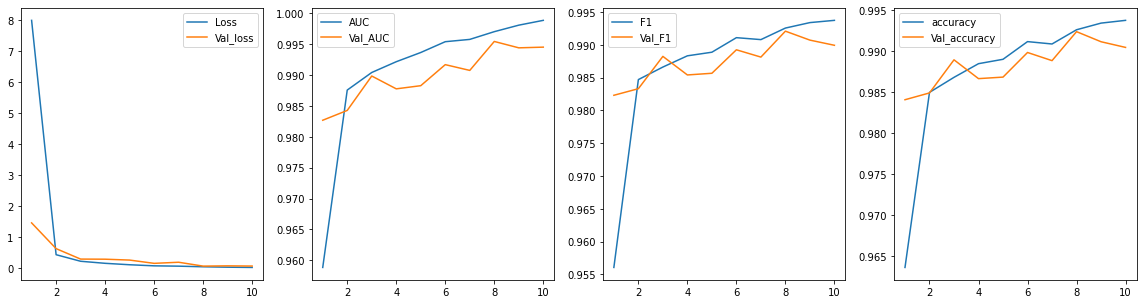

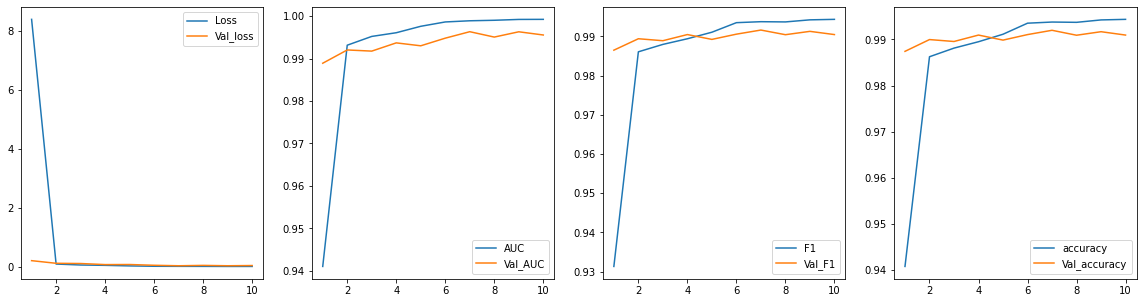

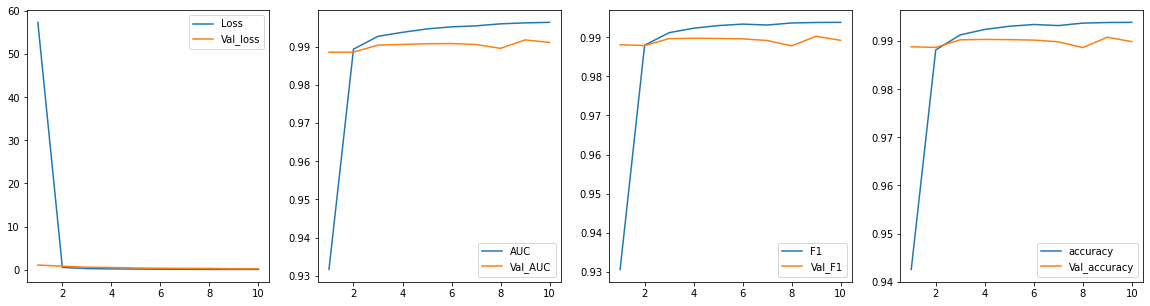

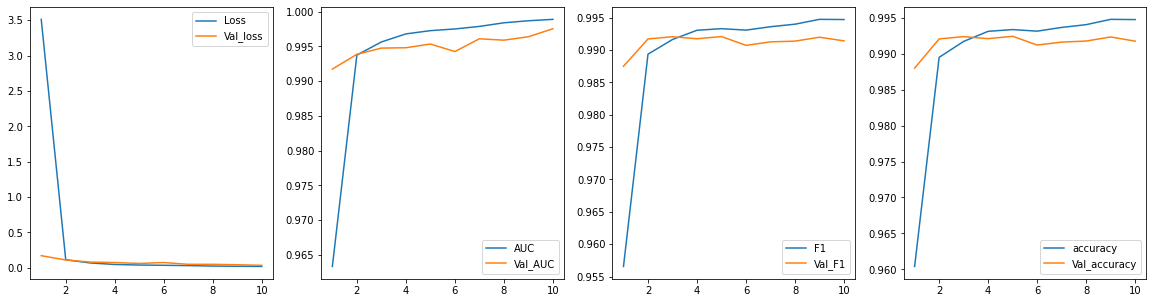

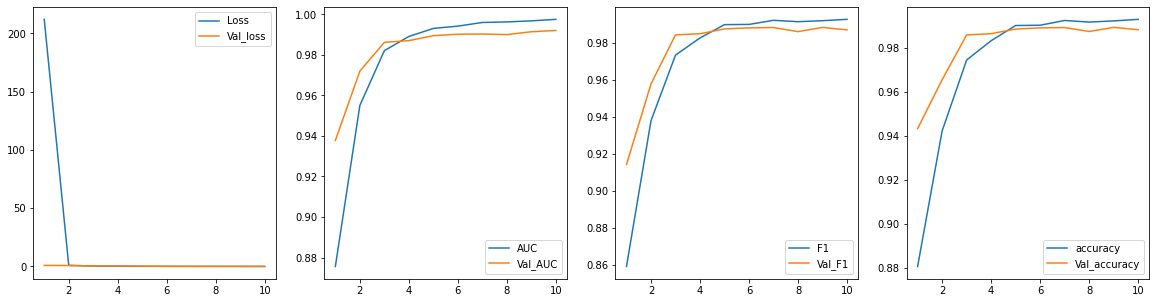

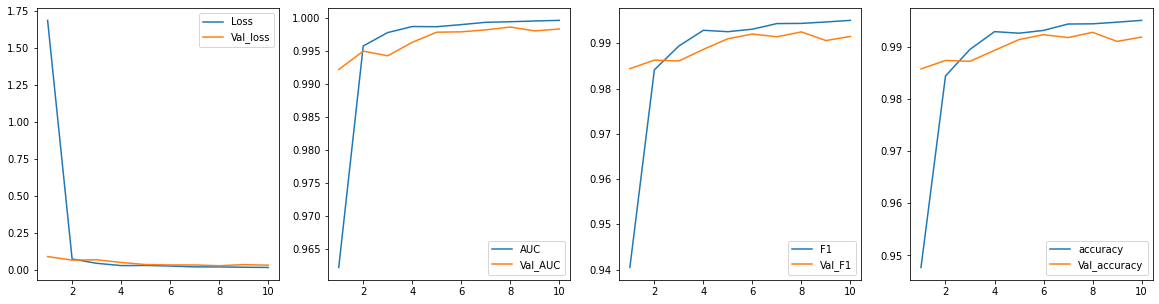

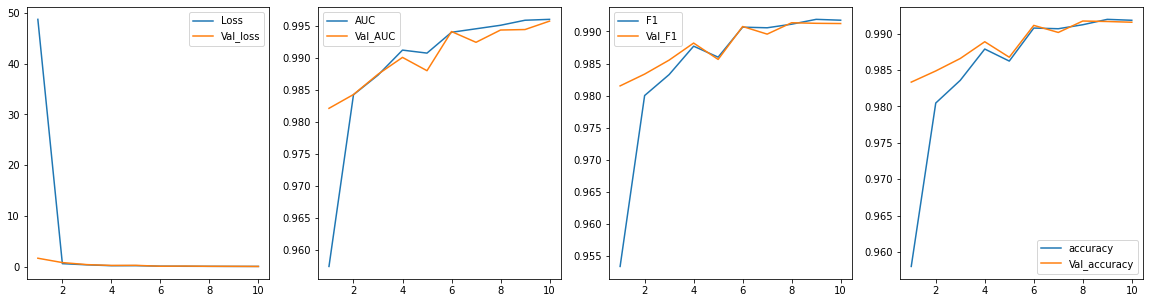

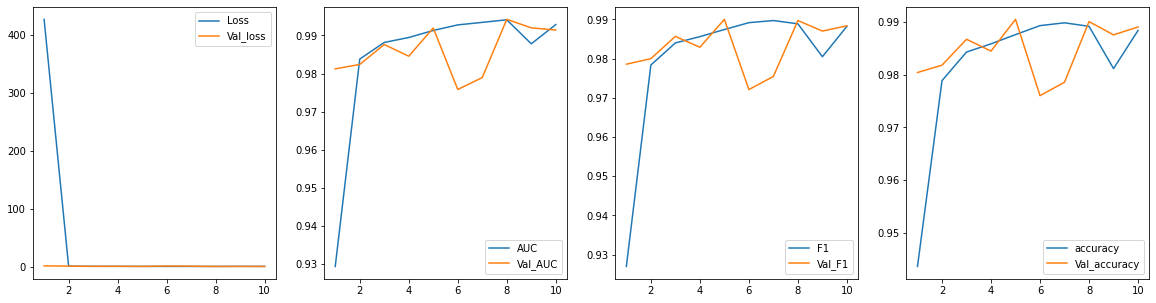

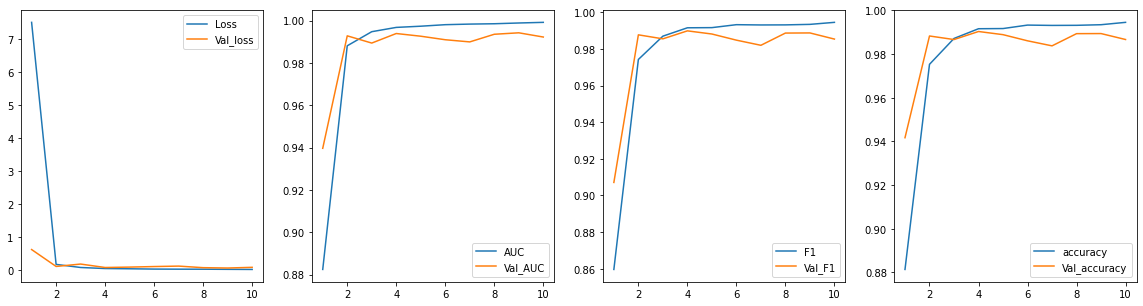

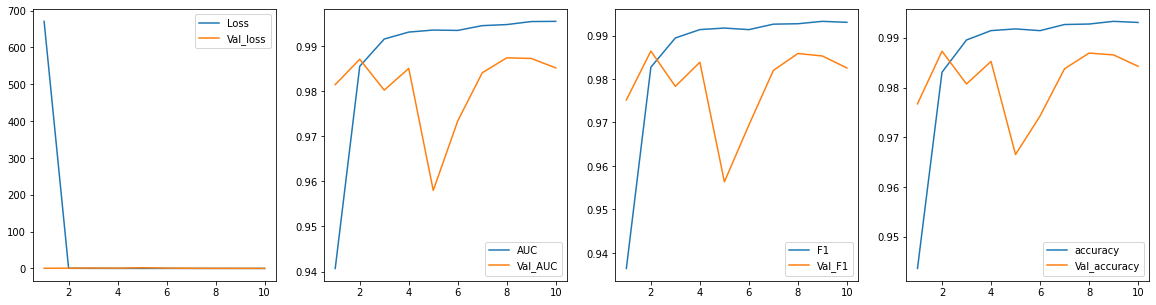

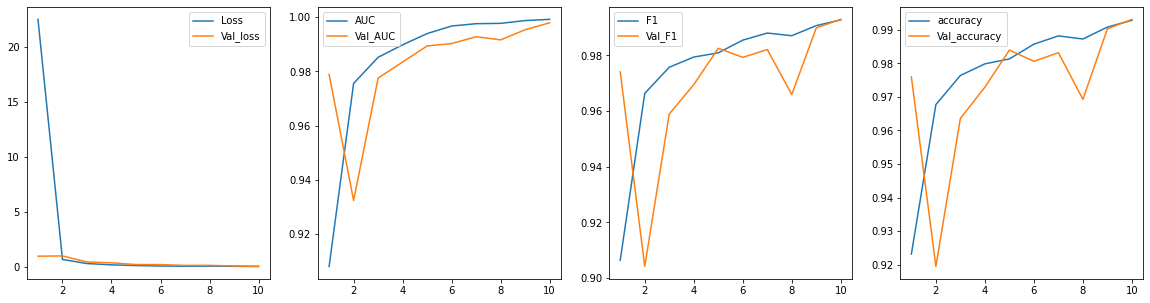

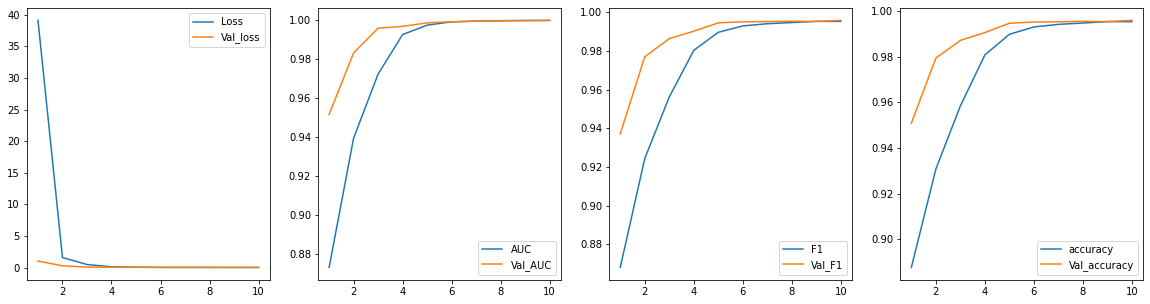

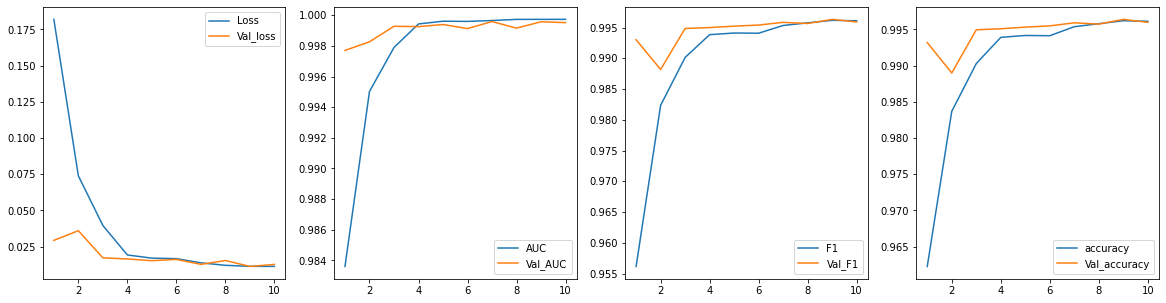

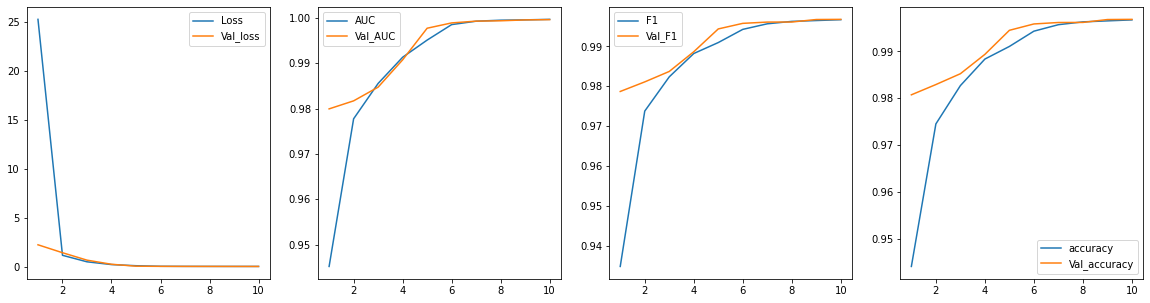

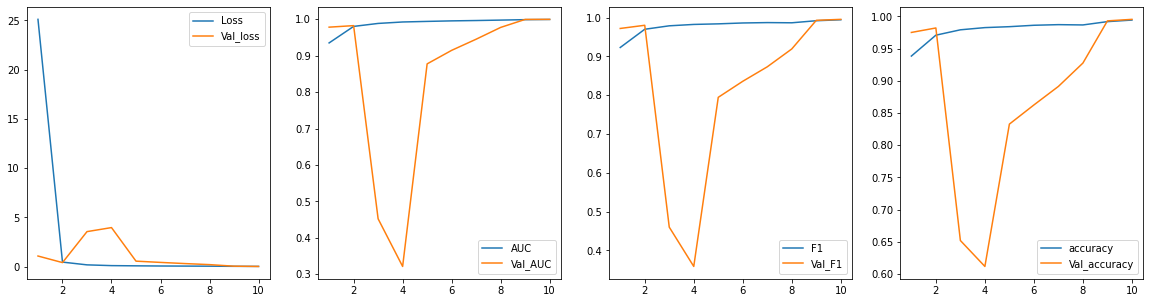

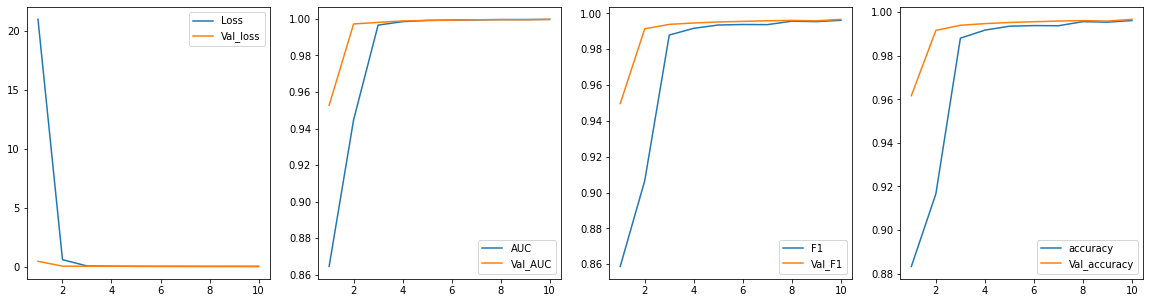

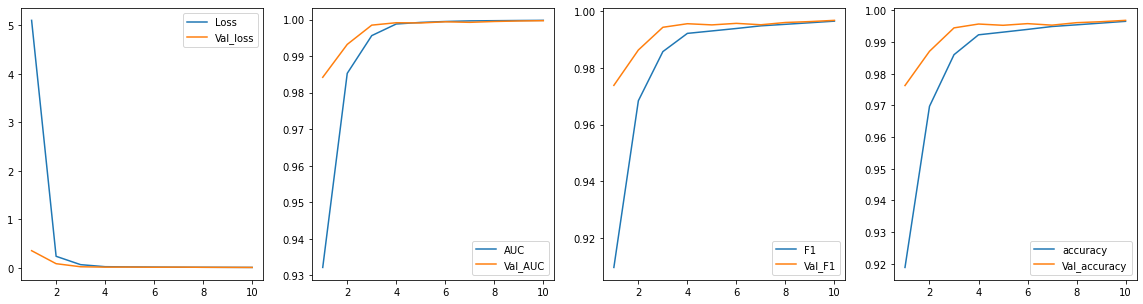

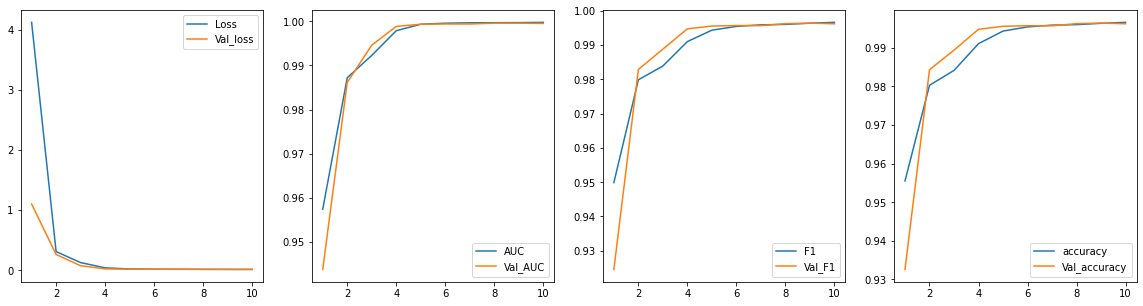

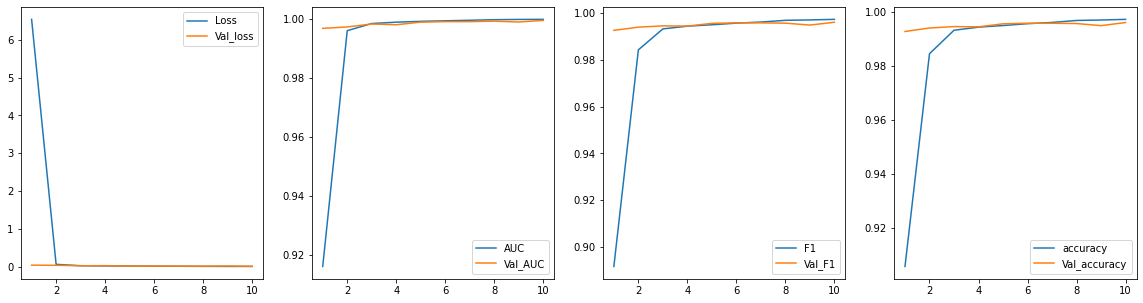

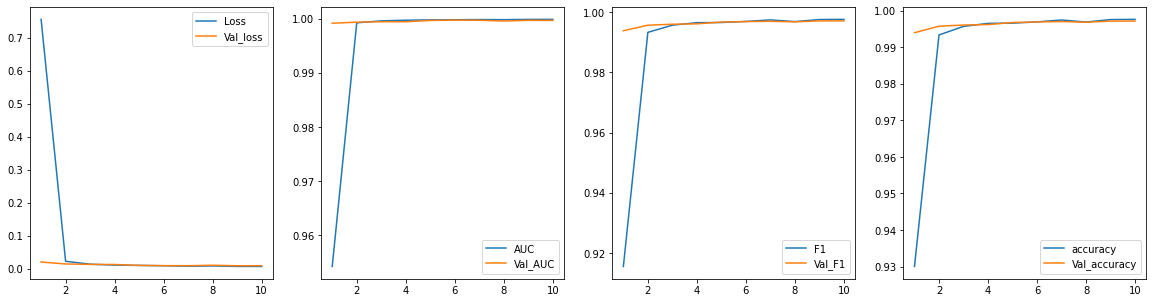

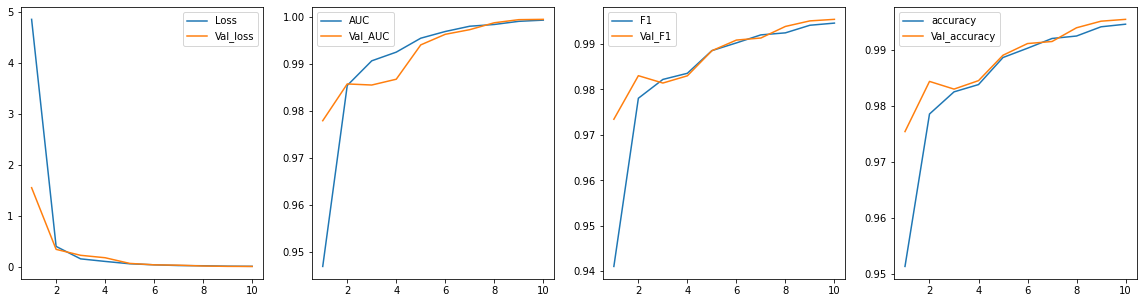

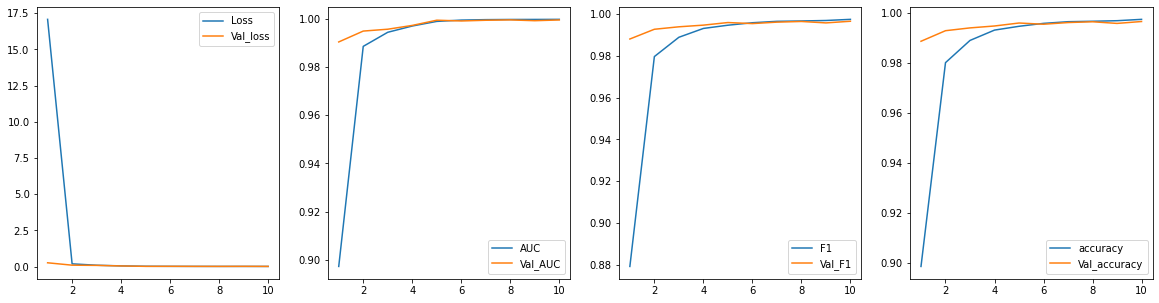

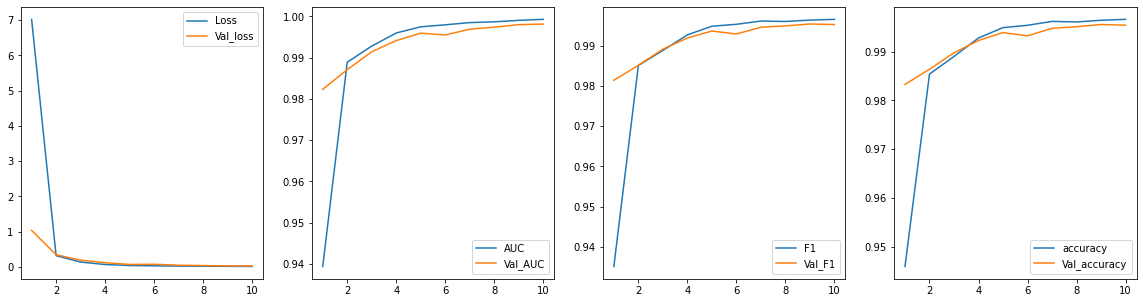

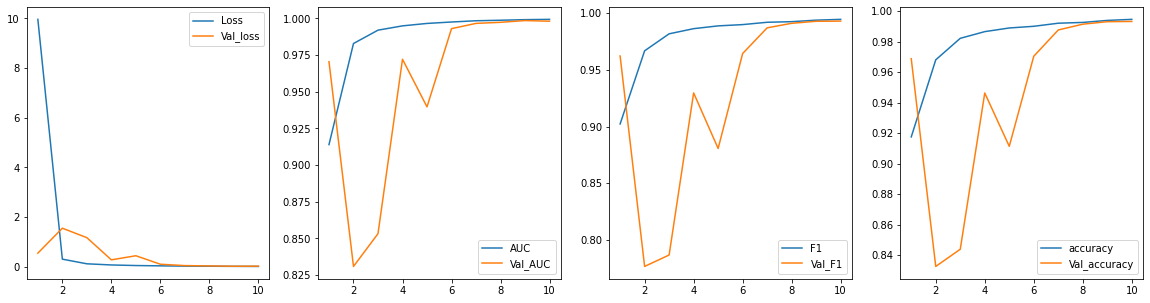

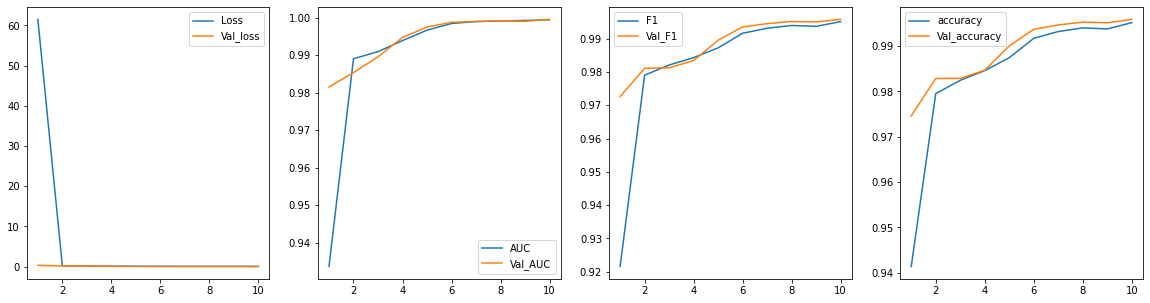

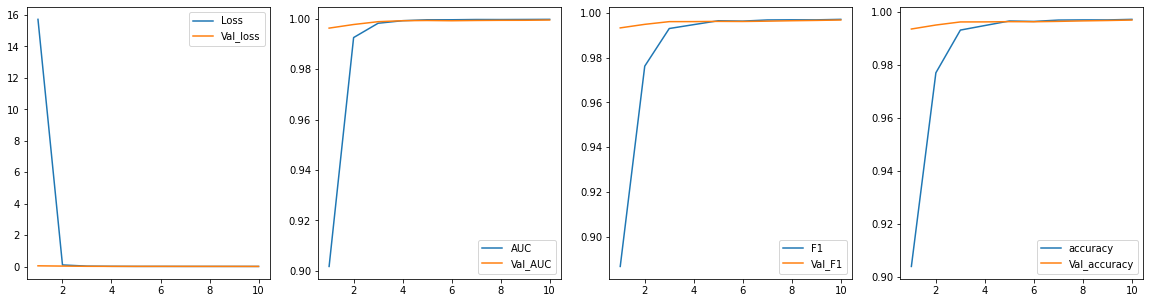

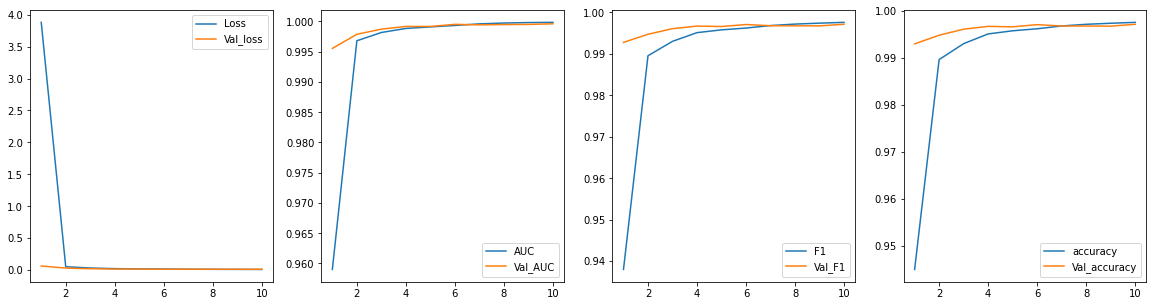

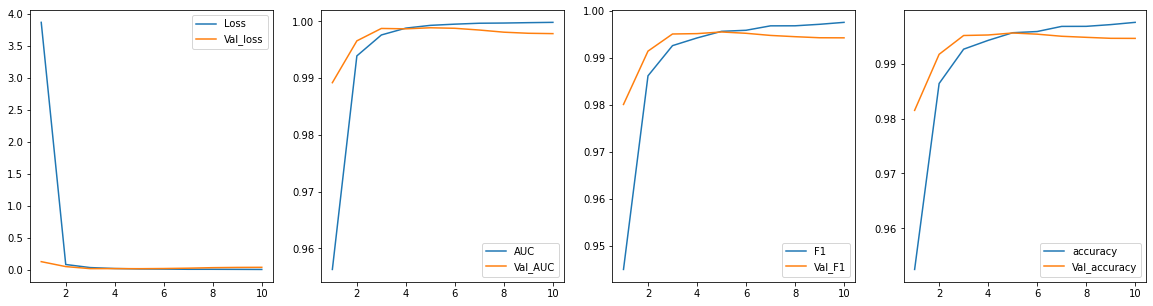

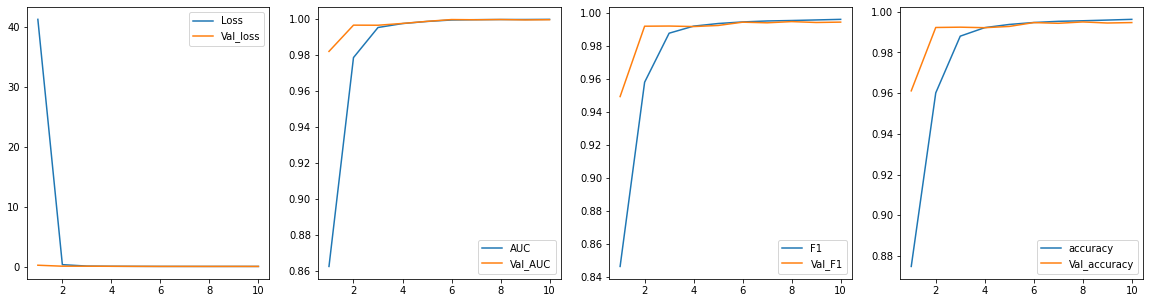

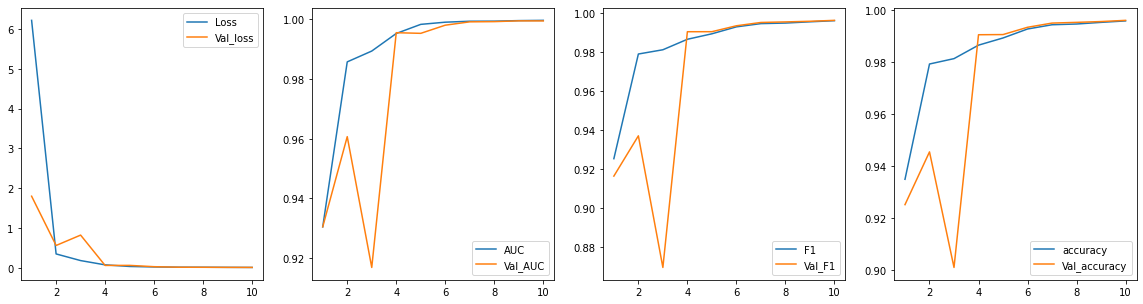

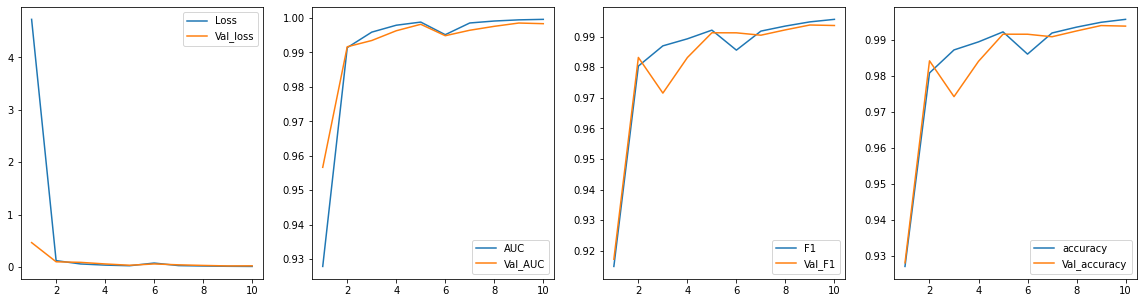

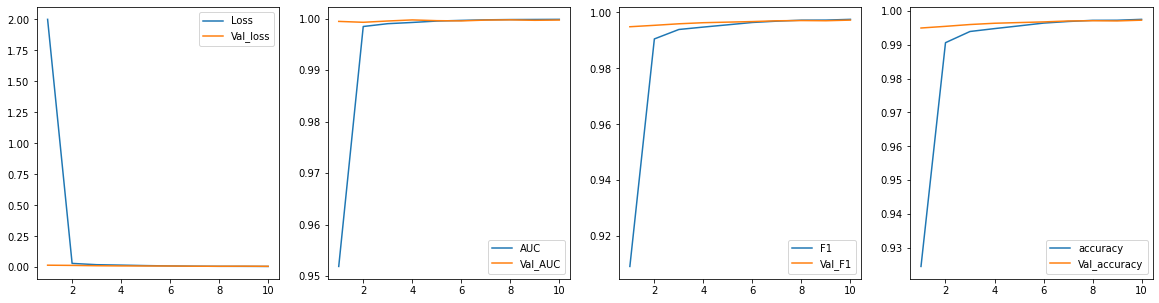

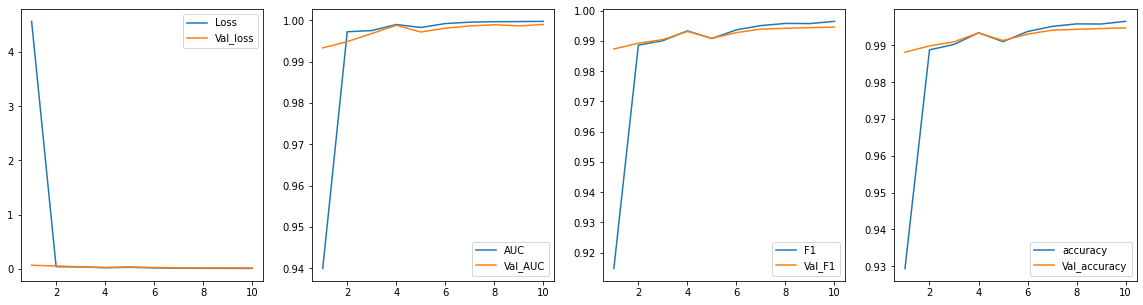

In [ ]:
import time

config={"architecture": "Unet",
                   "epochs": 10,
                   "batch_size": 16}

import pandas as pd
df = pd.DataFrame(columns=['Name', 'Loss', 'val_loss', "auc", "val_auc", "accuracy", "val_accuracy", "f1", "val_f1"])

for i in range(0, len(list(configs_multi))):
  run = wandb.init(project='kl-121-dissertation', reinit=True, config=config)
  print(i + 1, " loaded \n")
  conf = configs_multi[list(configs_multi)[i]]
  print(conf.PROJECT_TITLE, conf.type_)
  preproc = preprocessing.Preprocessor(conf)
  training = preproc.get_training_dataset("Train_in_Thailand/")
  evaluation = preproc.get_eval_dataset("Train_in_Thailand/")
  model.CONFIG = conf
  EPOCHS = 10
  wandb.run.name = "Multiview_2" + conf.PROJECT_TITLE
  start = time.time()
  EPO = [i for i in range(1, EPOCHS + 1)]
  model_custom = model.get_model_multiview_2()
  
  history = model_custom.fit(
      x=training,
      epochs=EPOCHS,
      steps_per_epoch=int(240*3 / conf.BATCH_SIZE),
      validation_data=evaluation,
      validation_steps=240*2,
      callbacks=[WandbCallback()]
      )
  end = time.time()
  print(f'Time for {EPOCHS} epochs is: ', end - start)
  Model_name = conf.PROJECT_TITLE + "_EPOCHS_" + str(EPOCHS)
  MODEL_DIR = 'gs://' + conf.BUCKET + "/" + conf.FOLDER + "/Models/" + Model_name
  model_custom.save(MODEL_DIR, save_format='tf')
  hist_keys = [*history.history]

  df.loc[i] = [conf.PROJECT_TITLE] + \
  [history.history["loss"][-1]] + [history.history["val_loss"][-1]] + \
  [history.history["auc"][-1]] + [history.history["val_auc"][-1]] + \
  [history.history["categorical_accuracy"][-1]] + [history.history["val_categorical_accuracy"][-1]] + \
  [history.history["f1"][-1]] + [history.history["val_f1"][-1]] \

  import matplotlib.pyplot as plt
  fig, axes = plt.subplots(1,4, figsize=(20,5))
  axes[0].plot(EPO, history.history[hist_keys[0]])
  axes[0].plot(EPO, history.history[hist_keys[4]])
  axes[0].legend(['Loss', 'Val_loss'])
  axes[1].plot(EPO, history.history[hist_keys[1]])
  axes[1].plot(EPO, history.history[hist_keys[5]])
  axes[1].legend(['AUC', 'Val_AUC'])
  axes[2].plot(EPO, history.history[hist_keys[2]])
  axes[2].plot(EPO, history.history[hist_keys[6]])
  axes[2].legend(['F1', 'Val_F1'])
  axes[3].plot(EPO, history.history[hist_keys[3]])
  axes[3].plot(EPO, history.history[hist_keys[7]])
  axes[3].legend(['accuracy', 'Val_accuracy'])
  fig.savefig(f'{conf.PROJECT_TITLE} epoch{EPOCHS}.png')
  wandb.log({'Multiview_data_2': df})
  run.finish()

# Multiview-3


<b> The model </b>: Here we use the Keras implementation of the U-Net model. The modified U-Net model takes in three layers of inputs and each has a structure of UNET and and outputs per-pixel class probability. We will use categorical cross entropy as loss function and softmax as the last layer because we are working on a classification problem.

For each experiment, we will:
- Load the training and evaluation dataset from google cloud bucket into a `tf.data.Dataset`.
- Train the Multiview deep learning with 3 inputs  UNET model for 10 epochs
- Store the trained model in google cloud bucket for future prediction
- Store the losses and metrics using Wandb.ai

<b> Note:</b> The time to train the model could take up to 1-2 hours because we are training 8 UNET model that is not pretrained, but this is within the colab background execution runtime. If the connection cuts off, the experiment is continued where the training stops.

In [ ]:
import time
import pandas as pd

config={"architecture": "Unet",
                   "epochs": 10,
                   "batch_size": 16}

df = pd.DataFrame(columns=['Name', 'Loss', 'val_loss', "auc", "val_auc", "accuracy", "val_accuracy", "f1", "val_f1"])

for i in range(0, len(list(configs_multi_3))):
  run = wandb.init(project='kl-121-dissertation', reinit=True, config=config)
  print(i + 1, " loaded \n")
  conf = configs_multi_3[list(configs_multi_3)[i]]
  print(conf.PROJECT_TITLE, conf.type_)
  preproc = preprocessing.Preprocessor(conf)
  training = preproc.get_training_dataset("Train_in_Thailand/")
  evaluation = preproc.get_eval_dataset("Train_in_Thailand/")
  model.CONFIG = conf
  EPOCHS = 10
  wandb.run.name = "Multiview_3" + conf.PROJECT_TITLE
  start = time.time()
  EPO = [i for i in range(1, EPOCHS + 1)]
  model_custom = model.get_model_multiview_3()
  
  history = model_custom.fit(
      x=training,
      epochs=EPOCHS,
      steps_per_epoch=int(240*3 / conf.BATCH_SIZE),
      validation_data=evaluation,
      validation_steps=240*2,
      callbacks=[WandbCallback()]
      )
  end = time.time()
  print(f'Time for {EPOCHS} epochs is: ', end - start)
  Model_name = conf.PROJECT_TITLE + "_EPOCHS_" + str(EPOCHS)
  MODEL_DIR = 'gs://' + conf.BUCKET + "/" + conf.FOLDER + "/Models/" + Model_name
  model_custom.save(MODEL_DIR, save_format='tf')
  hist_keys = [*history.history]

  df.loc[i] = [conf.PROJECT_TITLE] + \
  [history.history["loss"][-1]] + [history.history["val_loss"][-1]] + \
  [history.history["auc"][-1]] + [history.history["val_auc"][-1]] + \
  [history.history["categorical_accuracy"][-1]] + [history.history["val_categorical_accuracy"][-1]] + \
  [history.history["f1"][-1]] + [history.history["val_f1"][-1]] \

  wandb.log({'Multiview_data_3': df})
  run.finish()

auc,▁▆▇███████
categorical_accuracy,▁▅▆▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▅▆▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▇▇██████
val_categorical_accuracy,▁▄▆▇██████
val_f1,▁▄▆▇██████
val_loss,█▄▂▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99887


1  loaded 

L8SR_S1_as3 m3
Epoch 1/10
45/45 [==============================] - 104s 2s/step - loss: 9.5285 - auc: 0.9605 - categorical_accuracy: 0.9580 - f1: 0.9585 - val_loss: 0.9950 - val_auc: 0.9808 - val_categorical_accuracy: 0.9773 - val_f1: 0.9773 - _timestamp: 1658010421.0000 - _runtime: 117.0000
Epoch 2/10
45/45 [==============================] - 78s 2s/step - loss: 0.5318 - auc: 0.9817 - categorical_accuracy: 0.9748 - f1: 0.9747 - val_loss: 0.2020 - val_auc: 0.9879 - val_categorical_accuracy: 0.9752 - val_f1: 0.9752 - _timestamp: 1658010496.0000 - _runtime: 192.0000
Epoch 3/10
45/45 [==============================] - 68s 2s/step - loss: 0.2082 - auc: 0.9891 - categorical_accuracy: 0.9814 - f1: 0.9817 - val_loss: 0.0791 - val_auc: 0.9946 - val_categorical_accuracy: 0.9887 - val_f1: 0.9887 - _timestamp: 1658010566.0000 - _runtime: 262.0000
Epoch 4/10
45/45 [==============================] - 68s 2s/step - loss: 0.0955 - auc: 0.9941 - categorical_accuracy: 0.9889 - f1: 0.9891 - va

auc,▁▅▆▇▇█████
categorical_accuracy,▁▄▅▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▄▅▇▇█████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▆▇▇█████
val_categorical_accuracy,▂▁▅▇▇█████
val_f1,▂▁▅▇▇█████
val_loss,█▂▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99917


2  loaded 

L8SR_S1_el3 m3
Epoch 1/10
45/45 [==============================] - 107s 2s/step - loss: 281.5071 - auc: 0.8644 - categorical_accuracy: 0.8492 - f1: 0.8451 - val_loss: 1.5309 - val_auc: 0.8840 - val_categorical_accuracy: 0.8734 - val_f1: 0.8734 - _timestamp: 1658011323.0000 - _runtime: 118.0000
Epoch 2/10
45/45 [==============================] - 65s 1s/step - loss: 1.0597 - auc: 0.9379 - categorical_accuracy: 0.9140 - f1: 0.9141 - val_loss: 3.6009 - val_auc: 0.9555 - val_categorical_accuracy: 0.9534 - val_f1: 0.9534 - _timestamp: 1658011391.0000 - _runtime: 186.0000
Epoch 3/10
45/45 [==============================] - 70s 2s/step - loss: 0.2162 - auc: 0.9885 - categorical_accuracy: 0.9823 - f1: 0.9822 - val_loss: 0.4394 - val_auc: 0.9842 - val_categorical_accuracy: 0.9795 - val_f1: 0.9795 - _timestamp: 1658011459.0000 - _runtime: 254.0000
Epoch 4/10
45/45 [==============================] - 68s 2s/step - loss: 0.1332 - auc: 0.9930 - categorical_accuracy: 0.9892 - f1: 0.9892 - 

auc,▁▅▇███████
categorical_accuracy,▁▄▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▄▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▆▇▆▄▃█▇██
val_categorical_accuracy,▁▆█▆▃▁▇▅▇▆
val_f1,▁▆█▆▃▁▇▅▇▆
val_loss,▄█▂▂▂▂▁▁▁▁
GFLOPS,0.0
auc,0.99842


3  loaded 

L8SR_S1_sl3 m3
Epoch 1/10
45/45 [==============================] - 104s 2s/step - loss: 6.3151 - auc: 0.9522 - categorical_accuracy: 0.9127 - f1: 0.9138 - val_loss: 0.0251 - val_auc: 0.9993 - val_categorical_accuracy: 0.9921 - val_f1: 0.9921 - _timestamp: 1658012169.0000 - _runtime: 117.0000
Epoch 2/10
45/45 [==============================] - 68s 2s/step - loss: 0.0339 - auc: 0.9984 - categorical_accuracy: 0.9894 - f1: 0.9896 - val_loss: 0.0153 - val_auc: 0.9994 - val_categorical_accuracy: 0.9951 - val_f1: 0.9951 - _timestamp: 1658012236.0000 - _runtime: 184.0000
Epoch 3/10
45/45 [==============================] - 78s 2s/step - loss: 0.0192 - auc: 0.9993 - categorical_accuracy: 0.9941 - f1: 0.9935 - val_loss: 0.0140 - val_auc: 0.9994 - val_categorical_accuracy: 0.9954 - val_f1: 0.9954 - _timestamp: 1658012311.0000 - _runtime: 259.0000
Epoch 4/10
45/45 [==============================] - 77s 2s/step - loss: 0.0136 - auc: 0.9996 - categorical_accuracy: 0.9957 - f1: 0.9957 - va

auc,▁█████████
categorical_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▂▃▃▅▆▄▅▇█
val_categorical_accuracy,▁▅▅▆▇▇▇▇██
val_f1,▁▅▅▆▇▇▇▇██
val_loss,█▄▄▄▂▂▂▂▁▁
GFLOPS,0.0
auc,0.99985


4  loaded 

L8SR_S1_sl_el_as3 m3
Epoch 1/10
45/45 [==============================] - 106s 2s/step - loss: 11.0308 - auc: 0.9398 - categorical_accuracy: 0.9351 - f1: 0.9362 - val_loss: 0.3788 - val_auc: 0.9890 - val_categorical_accuracy: 0.9877 - val_f1: 0.9877 - _timestamp: 1658013066.0000 - _runtime: 118.0000
Epoch 2/10
45/45 [==============================] - 72s 2s/step - loss: 0.1946 - auc: 0.9928 - categorical_accuracy: 0.9906 - f1: 0.9907 - val_loss: 0.1069 - val_auc: 0.9949 - val_categorical_accuracy: 0.9932 - val_f1: 0.9932 - _timestamp: 1658013137.0000 - _runtime: 189.0000
Epoch 3/10
45/45 [==============================] - 69s 2s/step - loss: 0.0888 - auc: 0.9955 - categorical_accuracy: 0.9934 - f1: 0.9935 - val_loss: 0.0743 - val_auc: 0.9962 - val_categorical_accuracy: 0.9948 - val_f1: 0.9948 - _timestamp: 1658013205.0000 - _runtime: 257.0000
Epoch 4/10
45/45 [==============================] - 72s 2s/step - loss: 0.0533 - auc: 0.9969 - categorical_accuracy: 0.9950 - f1: 0.99

auc,▁▇████████
categorical_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▅▆▆▇▇█▇██
val_categorical_accuracy,▁▅▇▇▇█████
val_f1,▁▅▇▇▇█████
val_loss,█▃▂▂▂▁▁▁▁▁
GFLOPS,0.0
auc,0.99922


5  loaded 

L8SR_S1A_as3 m3
Epoch 1/10
45/45 [==============================] - 107s 2s/step - loss: 5.5656 - auc: 0.9523 - categorical_accuracy: 0.9476 - f1: 0.9484 - val_loss: 0.9666 - val_auc: 0.9822 - val_categorical_accuracy: 0.9815 - val_f1: 0.9815 - _timestamp: 1658013975.0000 - _runtime: 115.0000
Epoch 2/10
45/45 [==============================] - 70s 2s/step - loss: 0.2563 - auc: 0.9899 - categorical_accuracy: 0.9862 - f1: 0.9861 - val_loss: 0.1805 - val_auc: 0.9920 - val_categorical_accuracy: 0.9899 - val_f1: 0.9899 - _timestamp: 1658014048.0000 - _runtime: 188.0000
Epoch 3/10
45/45 [==============================] - 70s 2s/step - loss: 0.1002 - auc: 0.9946 - categorical_accuracy: 0.9916 - f1: 0.9917 - val_loss: 0.1705 - val_auc: 0.9921 - val_categorical_accuracy: 0.9897 - val_f1: 0.9897 - _timestamp: 1658014118.0000 - _runtime: 258.0000
Epoch 4/10
45/45 [==============================] - 72s 2s/step - loss: 0.0647 - auc: 0.9961 - categorical_accuracy: 0.9935 - f1: 0.9935 - v

auc,▁▇▇▇██████
categorical_accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▆▇███████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▅▅▇█▇████
val_categorical_accuracy,▁▅▅██▇▇█▇█
val_f1,▁▅▅██▇▇█▇█
val_loss,█▂▂▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99958


6  loaded 

L8SR_S1A_el3 m3
Epoch 1/10
45/45 [==============================] - 119s 2s/step - loss: 31.1039 - auc: 0.8915 - categorical_accuracy: 0.8855 - f1: 0.8859 - val_loss: 0.2390 - val_auc: 0.9883 - val_categorical_accuracy: 0.9754 - val_f1: 0.9754 - _timestamp: 1658014916.0000 - _runtime: 130.0000
Epoch 2/10
45/45 [==============================] - 66s 1s/step - loss: 0.2889 - auc: 0.9875 - categorical_accuracy: 0.9825 - f1: 0.9828 - val_loss: 0.6661 - val_auc: 0.9528 - val_categorical_accuracy: 0.9300 - val_f1: 0.9300 - _timestamp: 1658014985.0000 - _runtime: 199.0000
Epoch 3/10
45/45 [==============================] - 68s 2s/step - loss: 0.1583 - auc: 0.9917 - categorical_accuracy: 0.9871 - f1: 0.9871 - val_loss: 0.2534 - val_auc: 0.9907 - val_categorical_accuracy: 0.9890 - val_f1: 0.9890 - _timestamp: 1658015053.0000 - _runtime: 267.0000
Epoch 4/10
45/45 [==============================] - 69s 2s/step - loss: 0.0914 - auc: 0.9947 - categorical_accuracy: 0.9910 - f1: 0.9909 - 

auc,▁▇████████
categorical_accuracy,▁▇████████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇████████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▇▁███▇█▅██
val_categorical_accuracy,▆▁███▅█▂██
val_f1,▆▁███▅█▂██
val_loss,▃█▃▂▃▂▂▃▁▁
GFLOPS,0.0
auc,0.99713


7  loaded 

L8SR_S1A_sl3 m3
Epoch 1/10
45/45 [==============================] - 106s 2s/step - loss: 5.5859 - auc: 0.9614 - categorical_accuracy: 0.9418 - f1: 0.9427 - val_loss: 0.0606 - val_auc: 0.9944 - val_categorical_accuracy: 0.9894 - val_f1: 0.9894 - _timestamp: 1658015801.0000 - _runtime: 117.0000
Epoch 2/10
45/45 [==============================] - 66s 2s/step - loss: 0.0588 - auc: 0.9959 - categorical_accuracy: 0.9888 - f1: 0.9886 - val_loss: 33.0295 - val_auc: 0.4074 - val_categorical_accuracy: 0.4264 - val_f1: 0.4264 - _timestamp: 1658015870.0000 - _runtime: 186.0000
Epoch 3/10
45/45 [==============================] - 72s 2s/step - loss: 0.0396 - auc: 0.9975 - categorical_accuracy: 0.9905 - f1: 0.9904 - val_loss: 0.0240 - val_auc: 0.9988 - val_categorical_accuracy: 0.9927 - val_f1: 0.9927 - _timestamp: 1658015939.0000 - _runtime: 255.0000
Epoch 4/10
45/45 [==============================] - 70s 2s/step - loss: 0.0289 - auc: 0.9983 - categorical_accuracy: 0.9926 - f1: 0.9925 - 

auc,▁▇████████
categorical_accuracy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,█▁████████
val_categorical_accuracy,█▁████████
val_f1,█▁████████
val_loss,▁█▁▁▁▁▁▁▁▁
GFLOPS,0.0
auc,0.99983


8  loaded 

L8SR_S1A_sl_el_as3 m3
Epoch 1/10
45/45 [==============================] - 160s 2s/step - loss: 1156.0659 - auc: 0.9255 - categorical_accuracy: 0.9223 - f1: 0.9234 - val_loss: 1.0874 - val_auc: 0.9829 - val_categorical_accuracy: 0.9813 - val_f1: 0.9813 - _timestamp: 1658016760.0000 - _runtime: 172.0000
Epoch 2/10
45/45 [==============================] - 83s 2s/step - loss: 0.4887 - auc: 0.9856 - categorical_accuracy: 0.9816 - f1: 0.9814 - val_loss: 0.3059 - val_auc: 0.9885 - val_categorical_accuracy: 0.9850 - val_f1: 0.9850 - _timestamp: 1658016840.0000 - _runtime: 252.0000
Epoch 3/10
45/45 [==============================] - 76s 2s/step - loss: 0.2519 - auc: 0.9887 - categorical_accuracy: 0.9834 - f1: 0.9834 - val_loss: 0.4210 - val_auc: 0.9871 - val_categorical_accuracy: 0.9857 - val_f1: 0.9856 - _timestamp: 1658016923.0000 - _runtime: 335.0000
Epoch 4/10
45/45 [==============================] - 69s 2s/step - loss: 0.1724 - auc: 0.9916 - categorical_accuracy: 0.9872 - f1: 0

auc,▁▇▇███████
categorical_accuracy,▁▇▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
f1,▁▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁
val_auc,▁▄▃▅▆▇▇▇██
val_categorical_accuracy,▁▃▄▅▆▇▇▇██
val_f1,▁▃▄▅▆▇▇▇██
val_loss,█▃▃▂▂▂▁▁▁▁
GFLOPS,0.0
auc,0.99626


In [ ]:
history.history["loss"][-1]

0.01777116395533085

In [ ]:
  df.loc[0] = [conf.PROJECT_TITLE] + \
  [history.history["loss"][-1]] + [history.history["val_loss"][-1]] + \
  [history.history["auc"][-1]] + [history.history["val_auc"][-1]] + \
  [history.history["categorical_accuracy"][-1]] + [history.history["val_categorical_accuracy"][-1]] + \
  [history.history["f1"][-1]] + [history.history["val_f1"][-1]] \

In [ ]:
history.history['val_loss']

[1.3036359548568726,
 0.6631521582603455,
 0.16028621792793274,
 0.07809153199195862,
 0.03705950453877449,
 0.03628675639629364,
 0.029627371579408646,
 0.020635314285755157,
 0.017422711476683617,
 0.015400433912873268]

In [ ]:
history.history["loss"]

[17.891456604003906,
 0.5923821330070496,
 0.3210136592388153,
 0.14545297622680664,
 0.07615116238594055,
 0.05460277572274208,
 0.04297551140189171,
 0.03128247335553169,
 0.026329148560762405,
 0.022573361173272133]

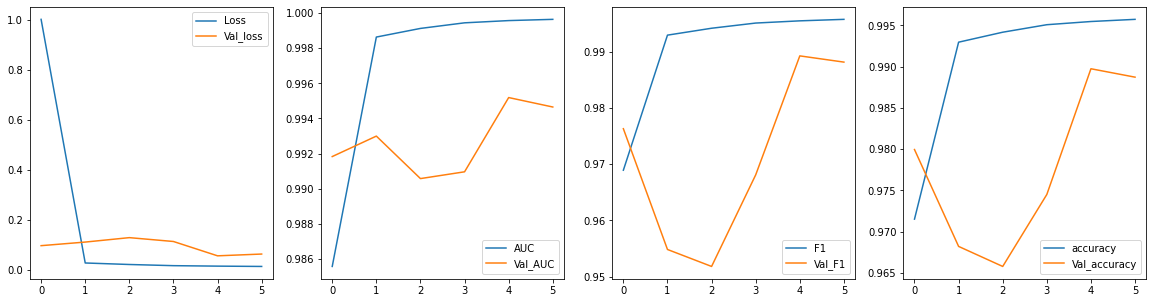

In [ ]:
import matplotlib.pyplot as plt
EPO = [i for i in range(6)]
fig, axes = plt.subplots(1,4, figsize=(20,5))
axes[0].plot(EPO, history.history[hist_keys[0]])
axes[0].plot(EPO, history.history[hist_keys[4]])
axes[0].legend(['Loss', 'Val_loss'])
axes[1].plot(EPO, history.history[hist_keys[1]])
axes[1].plot(EPO, history.history[hist_keys[5]])
axes[1].legend(['AUC', 'Val_AUC'])
axes[2].plot(EPO, history.history[hist_keys[2]])
axes[2].plot(EPO, history.history[hist_keys[6]])
axes[2].legend(['F1', 'Val_F1'])
axes[3].plot(EPO, history.history[hist_keys[3]])
axes[3].plot(EPO, history.history[hist_keys[7]])
axes[3].legend(['accuracy', 'Val_accuracy'])

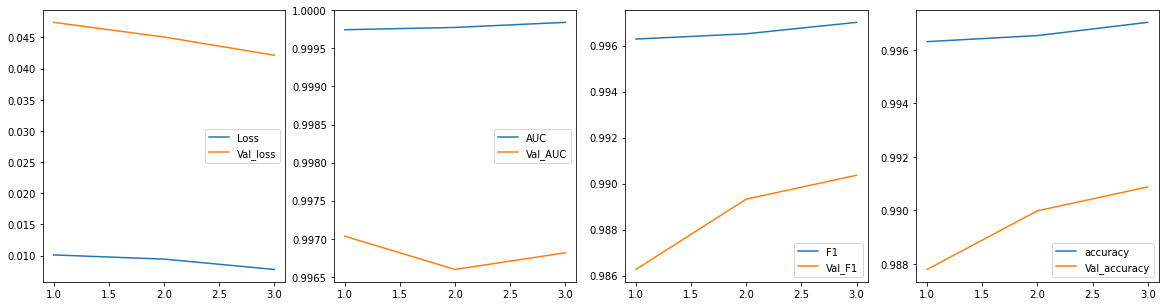

In [ ]:
hist_keys = [*history.history]

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,4, figsize=(20,5))
axes[0].plot(EPO, history.history[hist_keys[0]])
axes[0].plot(EPO, history.history[hist_keys[4]])
axes[0].legend(['Loss', 'Val_loss'])
axes[1].plot(EPO, history.history[hist_keys[1]])
axes[1].plot(EPO, history.history[hist_keys[5]])
axes[1].legend(['AUC', 'Val_AUC'])
axes[2].plot(EPO, history.history[hist_keys[2]])
axes[2].plot(EPO, history.history[hist_keys[6]])
axes[2].legend(['F1', 'Val_F1'])
axes[3].plot(EPO, history.history[hist_keys[3]])
axes[3].plot(EPO, history.history[hist_keys[7]])
axes[3].legend(['accuracy', 'Val_accuracy'])
fig.savefig(f'epoch{EPOCHS}.png')

In [ ]:
MODEL_DIR_1 = 'gs://' + config.BUCKET + "/" + config.FOLDER + "/Models/" + config.PROJECT_TITLE + "_EPOCHS_" + str(1)
MODEL_DIR_2 = 'gs://' + config.BUCKET + "/" + config.FOLDER + "/Models/" + config.PROJECT_TITLE + "_EPOCHS_" + str(2)
MODEL_DIR_3 = 'gs://' + config.BUCKET + "/" + config.FOLDER + "/Models/" + config.PROJECT_TITLE + "_EPOCHS_" + str(3)

print("loading...", MODEL_DIR_1)
model_custom_1EP = tf.keras.models.load_model(MODEL_DIR_1, custom_objects={'f1':metrics_.f1, "custom_accuracy": metrics_.custom_accuracy})
print("loading...", MODEL_DIR_2)
model_custom_2EP = tf.keras.models.load_model(MODEL_DIR_2, custom_objects={'f1':metrics_.f1, "custom_accuracy": metrics_.custom_accuracy})
print("loading...", MODEL_DIR_3)
model_custom_3EP = tf.keras.models.load_model(MODEL_DIR_3, custom_objects={'f1':metrics_.f1, "custom_accuracy": metrics_.custom_accuracy})

loading... gs://geebucketwater/Cnn_S1_SLOPE/Models/S1_SLOPE_EPOCHS_1
loading... gs://geebucketwater/Cnn_S1_SLOPE/Models/S1_SLOPE_EPOCHS_2
loading... gs://geebucketwater/Cnn_S1_SLOPE/Models/S1_SLOPE_EPOCHS_3
